# W261 Final Project: Click Through Rate Prediction
__`MIDS w261: Machine Learning at Scale | UC Berkeley School of Information | Fall 2018`__


# Section1: Introduction

Criteo Labs is an advertising platform that works with online retailers to personalized online display advertising to consumers who have visited the advertiser's website. Online advertising is a major business for internet companies and one of the core problem in that field is to be able to match the right advertisement to the right user at the right time. For ads on most websites and search engines, advertisers only pay for measurable user responses such are clicks on the ads and other actions that users take on the website such as registering, purchasing etc. Thus an optimal approach (as a search engine) is to choose an ad based on expected value, which is price of a click times the likelihood that the ad will be clicked.  Inappropriate advertising will result in worse user experience and wasted resources.  In order for websites to maximize expected value, they need to accurately predict the likelihood that a given ad will be clicked, also known as click-through rate (CTR).  

Scalability and machine learning are thus at the core of the company.  

# Notebook Set-Up


In [1]:
# imports
import re
import ast
import time
import numpy as np
import pandas as pd
import seaborn as sns
import networkx as nx
import matplotlib.pyplot as plt

In [2]:
%reload_ext autoreload
%autoreload 2

In [3]:
# store path to notebook
PWD = !pwd
PWD = PWD[0]

In [4]:
# start Spark Session
from pyspark.sql import SparkSession
app_name = "hw5_notebook"
master = "local[*]"
spark = SparkSession\
        .builder\
        .appName(app_name)\
        .master(master)\
        .getOrCreate()
sc = spark.sparkContext

In [5]:
from pyspark.sql import SQLContext
sqlContext = SQLContext(sc)

from pyspark.sql import functions as F

__`REMINDER`__: If you are running this notebook on the course docker container, you can monitor the progress of your jobs using the Spark UI at: http://localhost:4040/jobs/

# Section2: Problem definition


In this exercise, we will explore Criteo's click through data to understand and predict response rates. The data is one week's worth of browsing data shared as part of a Kaggle competition and the objective is to predict the probability that he will click on a given data given a user and the page that he is visitng. 

An ideal solution will not only have a high accuracy, but will also be fast to train, score, scalable and interpretable. While higher accuracy is better, a minimum of at least 85% is required to generate confidence in the model and to make the effort worthwhile (or just A/B testing might be a better alternative).  There are several other considerations like how many sub-models are expected eventually (based on product and demographics), how often scoring is expected to be done (weekly or daily or more often, etc), how often re-training needs to be done (adaptive vs static) that we currently do not have a lot of insight into but are critical in a real world scenario. We will also assume here that the cost of false positives and mis-classified predictions is limited to unrecognized revenue (in other words, an unresponsive ad does not result in future losses.   

Our problem at hand is a classification problem where we try to predict a binary response variable based on the click data. While there are several classification algorithms, we plan to use Logistic Regression as a starting point. Fusion methods that combine the simplicity of regressions with the complexity of something such as neural nets or ensembles have traditionally shown to work better than a single approach in the area of CTR, and ideally we would like to try a fusion approach, but given the time constraints we will use a Logistic Regression.

Need to edit and organize this better 
    

## Download the data

__File descriptions:__

* __train.txt__ - The training set consists of a portion of Criteo's traffic over a period of 7 days. Each row corresponds to a display ad served by Criteo. Positive (clicked) and negatives (non-clicked) examples have both been subsampled at different rates in order to reduce the dataset size. The examples are chronologically ordered.
* __test.txt__ - The test set is computed in the same way as the training set but for events on the day following the training period.



In [6]:
!mkdir data

mkdir: cannot create directory `data': File exists


In [20]:
def parse(line):
    fields = np.array(line.split('\t'))
    return(fields)

In [12]:
#Read data files

bigtrainRDD = sc.textFile('data/train.txt').cache()
# bigtrainRDD.count()

# bigtestRDD = sc.textFile('data/test.txt').cache()
# bigtestRDD.count()

In [8]:
# Create a temp sample - this is just to develop the code 
!head -n 2000 data/train.txt > data/train_top2000.txt
!head -n 2000 data/test.txt > data/test_top2000.txt

toptrainRDD = sc.textFile('data/train_top2000.txt').map(lambda k: k.split('\t')).cache()

# toptestRDD = sc.textFile('data/test_top2000.txt').cache()
print(toptrainRDD.count())

2000


In [9]:
# toptrainRDDCached = toptrainRDD.map(parse).cache()
# bigtrainRDDCached = bigtrainRDD.map(parse).cache() 

In [44]:
#Create a random sample
trainRDDsample=toptrainRDD.takeSample(False,20,seed=201812)
# len(trainRDDsample)

# testRDDsample=bigtestRDD.takeSample(False,2000).cache()

# Section3: Logistic Regression    

## Algorithm description with math


Math, etc

# Section4: EDA



__Data fields:__

* __Label__ - Target variable that indicates if an ad was clicked (1) or not (0).
* __I1-I13__ - A total of 13 columns of integer features (mostly count features).
* __C1-C26__ - A total of 26 columns of categorical features. The values of these features have been hashed onto 32 bits for anonymization purposes. The semantic of the features is undisclosed.

Since the names or descriptions of the fields are not available, below is a list of what we believe the fields used for a modeling exercise such as this should be:

1. An user id so we can track short term and long term patterns of a given customer/visitor. We exxpect brand loyalty to be a key factor for several consumer facing goods   
2. Date of the visit: seasonality is important, and so is day of the week, time of visit, etc  
3. Device based information : we can derive user-device based fields to see if certain uses are more responsive to say mobile vs web ads  
4. Placement of the ads/banner: size, location, orientation, color based features, etc  
5. Product based features  
6. Customer demographics  including product purchase history if available  
7. Any other relevant details: other marketing events, holidays, other offers the user may have received simulataneously or in the recent past
8. Geographical fields  

We do not have specific information of whether the available data is complete 1 week or sampled/sub-sampled and whether the non-responded ads are sampled at a different rate than responded ads. These are critical pieces of information in a real world scenario.  



## Response rate

In [11]:
## Histogram of fields
basedata=trainRDDsample

FIELDS=["Label","I1","I2","I3","I4","I5","I6","I7","I8","I9","I10","I11","I12","I13","C1","C2","C3","C4","C5","C6","C7","C8"
       ,"C9","C10","C11","C12","C13","C14","C15","C16","C17","C18","C19","C20","C21","C22","C23","C24","C25","C26"]

# sample = np.array(basedata.map(lambda x: x).takeSample(False, 2000))
pDF = pd.DataFrame(np.array(trainRDDsample), columns = FIELDS)



/opt/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:2: FutureWarning: convert_objects is deprecated.  To re-infer data dtypes for object columns, use DataFrame.infer_objects()
For all other conversions use the data-type specific converters pd.to_datetime, pd.to_timedelta and pd.to_numeric.
  


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f3481721a58>,
      dtype=object)

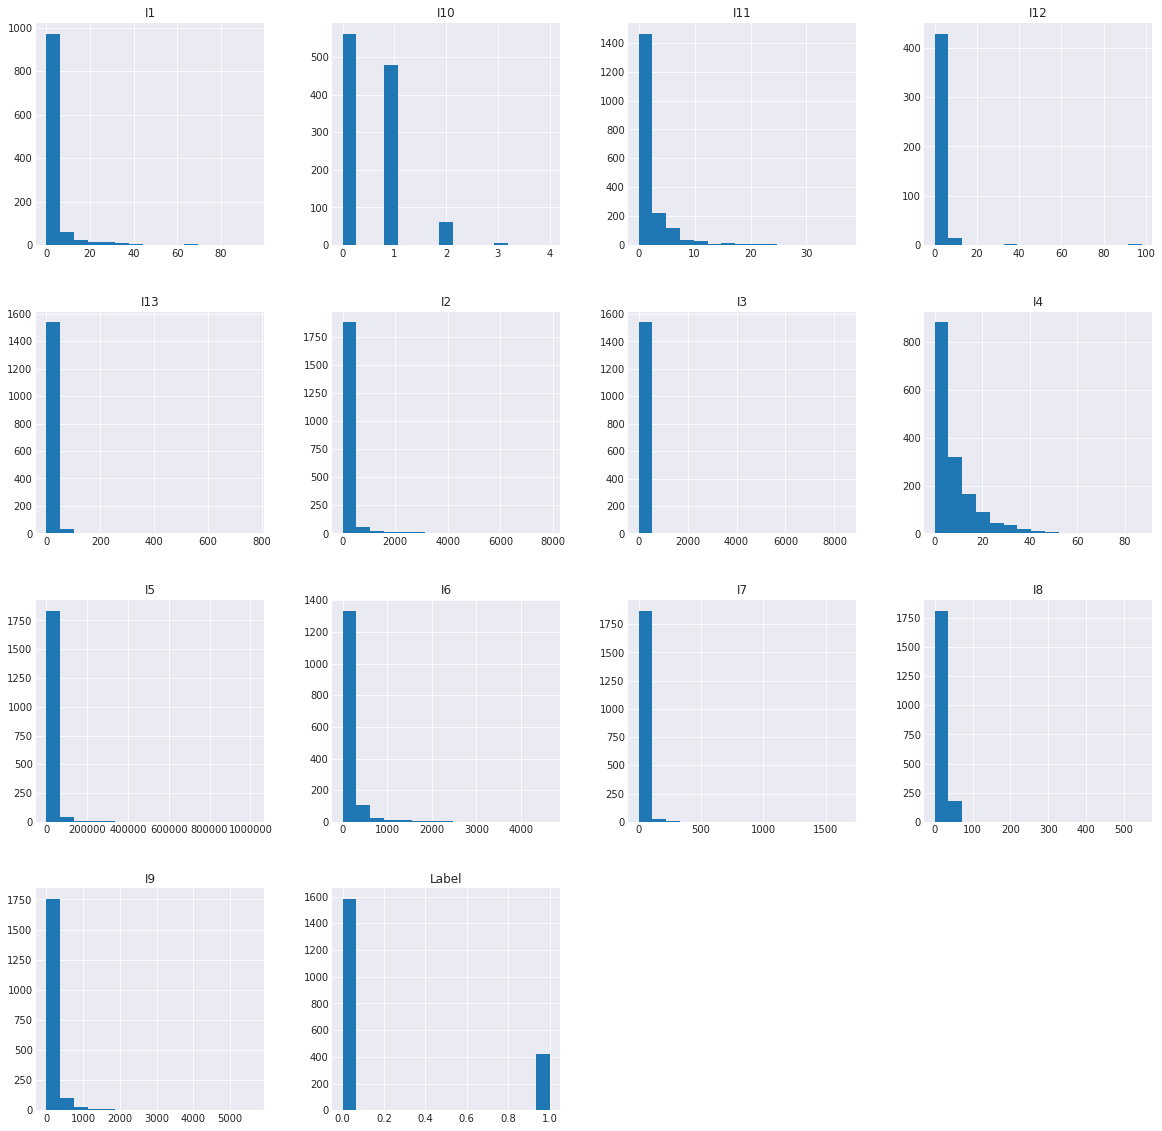

In [12]:
#Histogram of numeric fields
pDF[FIELDS[0:14]].convert_objects(convert_numeric=True).hist(figsize=(20,20), bins=15)


Number of unique values for  C1  :  79
Number of unique values for  C2  :  252
Number of unique values for  C3  :  1293
Number of unique values for  C4  :  1043
Number of unique values for  C5  :  30
Number of unique values for  C6  :  7
Number of unique values for  C7  :  1164
Number of unique values for  C8  :  39
Number of unique values for  C9  :  2
Number of unique values for  C10  :  908
Number of unique values for  C11  :  926
Number of unique values for  C12  :  1239
Number of unique values for  C13  :  824
Number of unique values for  C14  :  20
Number of unique values for  C15  :  819
Number of unique values for  C16  :  1159
Number of unique values for  C17  :  9
Number of unique values for  C18  :  534
Number of unique values for  C19  :  201
Number of unique values for  C20  :  4
Number of unique values for  C21  :  1204
Number of unique values for  C22  :  7
Number of unique values for  C23  :  12
Number of unique values for  C24  :  729
Number of unique values for  C25  

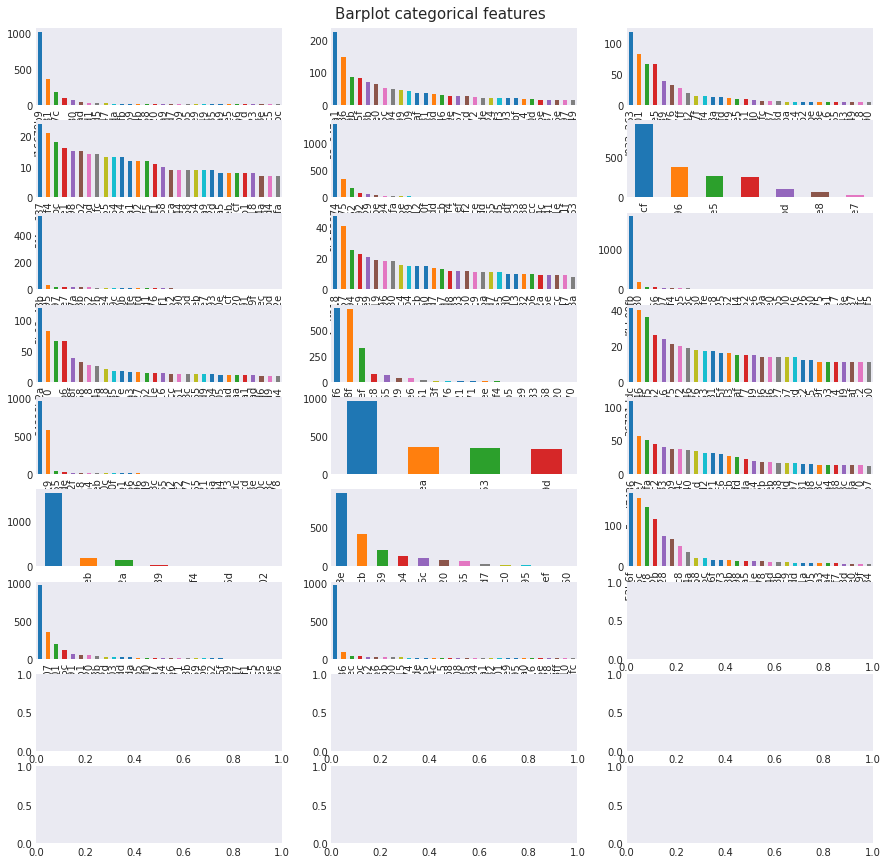

In [13]:
#Bar plot of categorical variables - plot top 30 values
fig, ax_grid = plt.subplots(9, 3, figsize=(15,15))
for idx, feature in enumerate(FIELDS[14:]):
    x = pDF[feature].value_counts()
    print("Number of unique values for ",feature," : ",x.shape[0])
    #sns.barplot(x, ax=ax_grid[idx//8][idx%3], orient='h', linewidth=.5)
    if (x.shape[0]<=30):
        x.plot(kind='bar',ax=ax_grid[idx//4][idx%3])
        ax_grid[idx//4][idx%3]
    else:
        x.head(30).plot(kind='bar',ax=ax_grid[idx//4][idx%3])
        ax_grid[idx//4][idx%3]
fig.suptitle("Barplot categorical features", fontsize=15, y=0.9)
plt.show()

In [14]:
#Number of missing values in each field

In [15]:
#Outliers

/opt/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:4: FutureWarning: convert_objects is deprecated.  To re-infer data dtypes for object columns, use Series.infer_objects()
For all other conversions use the data-type specific converters pd.to_datetime, pd.to_timedelta and pd.to_numeric.
  after removing the cwd from sys.path.


Mean of field  I1  :  3.6963963963963966
Mean of field  I2  :  120.2845
Mean of field  I3  :  33.05802707930368
Mean of field  I4  :  8.063924050632911
Mean of field  I5  :  14686.670162558994
Mean of field  I6  :  146.92563081009297
Mean of field  I7  :  13.703198741478763
Mean of field  I8  :  13.67867867867868
Mean of field  I9  :  126.69690613529103
Mean of field  I10  :  0.5612612612612613
Mean of field  I11  :  2.1557420031463033
Mean of field  I12  :  1.0426966292134832
Mean of field  I13  :  11.783544303797468


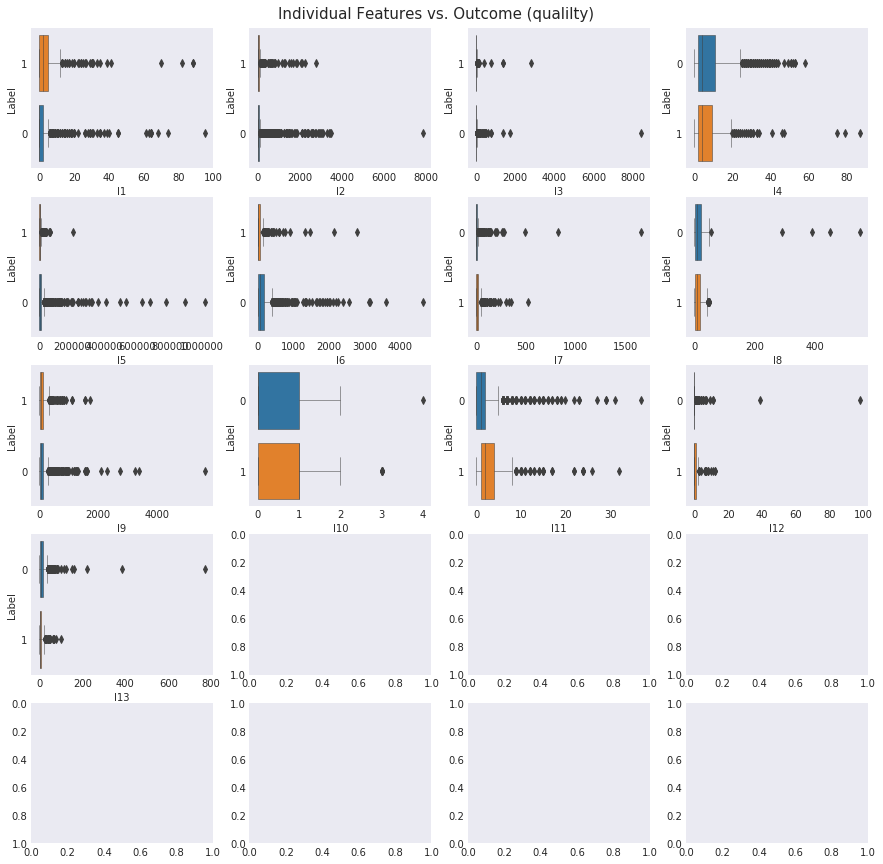

In [16]:
fig, ax_grid = plt.subplots(5, 4, figsize=(15,15))
y =  pDF['Label']
for idx, feature in enumerate(FIELDS[1:14]):
    x = pDF[feature].convert_objects(convert_numeric=True)
    print("Mean of field ",feature," : ",x.mean())
    sns.boxplot(x, y, ax=ax_grid[idx//4][idx%4], orient='h', linewidth=.5)
    ax_grid[idx//3][idx%4].invert_yaxis()
fig.suptitle("Individual Features vs. Outcome (qualilty)", fontsize=15, y=0.9)
plt.show()

In [17]:
pDF.describe()

,Label,I1,I2,I3,I4,I5,I6,I7,I8,I9,...,C17,C18,C19,C20,C21,C22,C23,C24,C25,C26
count,2000,2000,2000,2000,2000,2000,2000,2000,2000,2000,...,2000,2000,2000,2000,2000,2000,2000,2000,2000,2000
unique,2,48,344,148,56,1432,408,119,56,422,...,9,534,201,4,1204,7,12,729,33,554
top,0,,0,,,,,0,0,,...,e5ba7672,5aed7436,,,0014c32a,,32c7478e,aee52b6f,,
freq,1582,890,363,449,420,93,494,482,250,93,...,832,109,966,966,119,1632,926,178,966,966


/opt/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:1: FutureWarning: convert_objects is deprecated.  To re-infer data dtypes for object columns, use DataFrame.infer_objects()
For all other conversions use the data-type specific converters pd.to_datetime, pd.to_timedelta and pd.to_numeric.
  """Entry point for launching an IPython kernel.


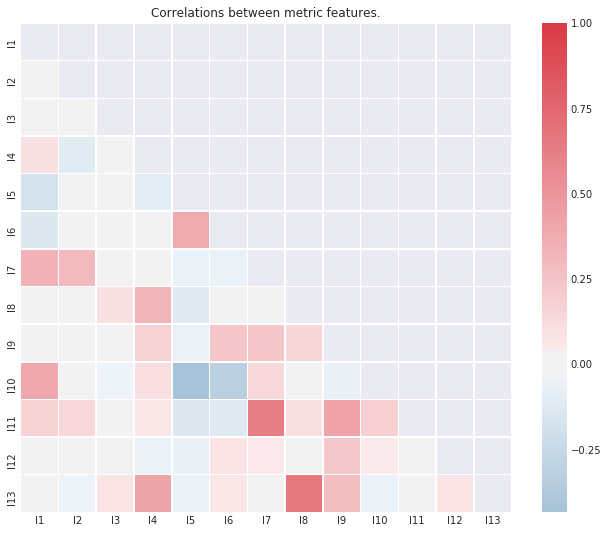

In [18]:
corr = pDF[FIELDS[1:14]].convert_objects(convert_numeric=True).corr()
fig, ax = plt.subplots(figsize=(11, 9))
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
cmap = sns.diverging_palette(240, 10, as_cmap=True)
sns.heatmap(corr, mask=mask, cmap=cmap, center=0, linewidths=.5)
plt.title("Correlations between metric features.")
plt.show()

#### Exploration: DataFrames and Parquet approach

In [19]:
# testdf=basedata.map(lambda x: (x, )).toDF()
# testdf.head()
# toptrainRDD

In [20]:
dataDF = sqlContext.read.option("delimiter", "\t").csv("/media/notebooks/Assignments/FinalProject/data/train_top2000.txt")
# data = sqlContext.read.option("delimiter", "\t").csv("/media/notebooks/Assignments/FinalProject/data/train.txt")

In [21]:
dataDF.printSchema()

root
 |-- _c0: string (nullable = true)
 |-- _c1: string (nullable = true)
 |-- _c2: string (nullable = true)
 |-- _c3: string (nullable = true)
 |-- _c4: string (nullable = true)
 |-- _c5: string (nullable = true)
 |-- _c6: string (nullable = true)
 |-- _c7: string (nullable = true)
 |-- _c8: string (nullable = true)
 |-- _c9: string (nullable = true)
 |-- _c10: string (nullable = true)
 |-- _c11: string (nullable = true)
 |-- _c12: string (nullable = true)
 |-- _c13: string (nullable = true)
 |-- _c14: string (nullable = true)
 |-- _c15: string (nullable = true)
 |-- _c16: string (nullable = true)
 |-- _c17: string (nullable = true)
 |-- _c18: string (nullable = true)
 |-- _c19: string (nullable = true)
 |-- _c20: string (nullable = true)
 |-- _c21: string (nullable = true)
 |-- _c22: string (nullable = true)
 |-- _c23: string (nullable = true)
 |-- _c24: string (nullable = true)
 |-- _c25: string (nullable = true)
 |-- _c26: string (nullable = true)
 |-- _c27: string (nullable = tru

In [22]:
#Number of missing values in each column
from pyspark.sql.functions import lit,col

rows = dataDF.count()
summary = dataDF.describe().filter(col("summary") == "count")
summary.select(*((lit(rows)-col(c)).alias(c) for c in dataDF.columns)).show()

+---+-----+---+-----+-----+----+-----+----+---+----+-----+----+------+-----+----+----+----+----+----+-----+----+----+----+----+----+----+----+----+----+----+----+----+-----+-----+----+------+----+----+-----+-----+
|_c0|  _c1|_c2|  _c3|  _c4| _c5|  _c6| _c7|_c8| _c9| _c10|_c11|  _c12| _c13|_c14|_c15|_c16|_c17|_c18| _c19|_c20|_c21|_c22|_c23|_c24|_c25|_c26|_c27|_c28|_c29|_c30|_c31| _c32| _c33|_c34|  _c35|_c36|_c37| _c38| _c39|
+---+-----+---+-----+-----+----+-----+----+---+----+-----+----+------+-----+----+----+----+----+----+-----+----+----+----+----+----+----+----+----+----+----+----+----+-----+-----+----+------+----+----+-----+-----+
|0.0|890.0|0.0|449.0|420.0|93.0|494.0|93.0|2.0|93.0|890.0|93.0|1555.0|420.0| 0.0| 0.0|66.0|66.0| 0.0|251.0| 0.0| 0.0| 0.0| 0.0| 0.0|66.0| 0.0| 0.0| 0.0|66.0| 0.0| 0.0|966.0|966.0|66.0|1632.0| 0.0|66.0|966.0|966.0|
+---+-----+---+-----+-----+----+-----+----+---+----+-----+----+------+-----+----+----+----+----+----+-----+----+----+----+----+----+----+----+--

In [23]:
print((dataDF.count(), len(dataDF.columns)))

(2000, 40)


In [24]:
#Try parquet - prob not required. Gives error second time as cannot overwrite parquet
# data.write.format("parquet").save("/media/notebooks/Assignments/FinalProject/data/data.parquet_small")
data_parquet = spark.read.parquet("/media/notebooks/Assignments/FinalProject/data/data.parquet_small")

# data.write.format("parquet").save("/media/notebooks/Assignments/FinalProject/data/data.parquet_alldata")
# data_parquet = spark.read.parquet("/media/notebooks/Assignments/FinalProject/data/data.parquet_alldata")

In [25]:
%%time
data_parquet.count()

CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 664 ms


2000

In [26]:
# data_parquet.write.partitionBy("label").parquet("hdfs://<namenode>:<port>/path/to/file")

In [27]:
#Mean by label
data_parquet.groupby(data_parquet._c0).agg(F.avg(data_parquet._c0),F.avg(data_parquet._c1),F.avg(data_parquet._c2),F.avg(data_parquet._c3),F.avg(data_parquet._c4),F.avg(data_parquet._c5),F.avg(data_parquet._c6),F.avg(data_parquet._c7),F.avg(data_parquet._c8),F.avg(data_parquet._c9),F.avg(data_parquet._c10),F.avg(data_parquet._c11),F.avg(data_parquet._c12),).collect()
# data_parquet.select(Seq("_c0", "_c1").map(mean(_)): _*).show()//
# data_parquet.select(Seq("_c0", "_c1").map(mean(_)): _*).show()
#Can expand this to more columns

[Row(_c0='0', avg(_c0)=0.0, avg(_c1)=3.032687651331719, avg(_c2)=124.69089759797724, avg(_c3)=32.51410153102337, avg(_c4)=8.171588188347965, avg(_c5)=17286.362908605737, avg(_c6)=169.09586631486368, avg(_c7)=11.283144570286476, avg(_c8)=14.096835443037975, avg(_c9)=127.81812125249833, avg(_c10)=0.48789346246973364, avg(_c11)=1.8540972684876749, avg(_c12)=0.9201183431952663),
 Row(_c0='1', avg(_c0)=1.0, avg(_c1)=5.626760563380282, avg(_c2)=103.60765550239235, avg(_c3)=35.23548387096774, avg(_c4)=7.651376146788991, avg(_c5)=5135.348039215686, avg(_c6)=78.61246612466125, avg(_c7)=22.65024630541872, avg(_c8)=12.098086124401913, avg(_c9)=122.55172413793103, avg(_c10)=0.7746478873239436, avg(_c11)=3.270935960591133, avg(_c12)=1.4299065420560748)]

In [28]:
# https://developer.ibm.com/hadoop/2016/01/14/5-reasons-to-choose-parquet-for-spark-sql/

## Toy example

In [36]:
# rdd = sc.textFile(myfile).map(lambda k: k.split('\t'))
# rdd=trainRDDsample.cache()
# df = trainRDDsample.toDF(FIELDS)
FIELDS1=['_c0','_c1','_c2','_c3','_c4','_c5','_c6','_c7','_c8','_c9','_c10','_c11','_c12','_c13','_c14','_c15','_c16','_c17','_c18','_c19','_c20','_c21','_c22','_c23','_c24','_c25','_c26','_c27','_c28','_c29','_c30','_c31','_c32','_c33','_c34','_c35','_c36','_c37','_c38','_c39']
TARGET = FIELDS1[0]
METRIC_FEATURES = FIELDS1[1:14]
CAT_FEATURES = FIELDS1[14:]

### Scaling Metric Features

In [38]:
from pyspark.sql.functions import min, max, col, lit,when,udf
from pyspark.sql.types import DoubleType

tmpDF = dataDF
for feature in METRIC_FEATURES:
     
    tmpDF = tmpDF.na.fill({feature: '0'})
    tmpDF = tmpDF.withColumn(feature,when(col(feature) == '', lit(0)).otherwise(col(feature).cast(DoubleType())))
    featureStats = tmpDF.agg(min(col(feature)), max(col(feature))).collect()
    max_value = featureStats[0][1]
    min_value = featureStats[0][0]
    udf_myFunction = udf(lambda z: (z - min_value) / (max_value - min_value), DoubleType())
    tmpDF = tmpDF.withColumn(feature, udf_myFunction(col(feature))) 
df = tmpDF

### Dummyfying Categorical Features

In [42]:
tmpDF = dataDF
for feature in CAT_FEATURES:
    featureValues = df.select(col(feature)).distinct().collect()
    for featureValue in featureValues:
        featureValue = featureValue[0]
        if featureValue is None:
            newColName = feature + "_" + "Blank"
        else:
            newColName = feature + "_" + featureValue
        tmpDF = tmpDF.withColumn(newColName,when(col(feature) == featureValue, lit(1)).otherwise(lit(0)))
        
tmpDF = tmpDF.drop(*FIELDS1[14:])
df = tmpDF

Py4JJavaError: An error occurred while calling o72830.withColumn.
: java.lang.StackOverflowError
	at org.apache.spark.sql.catalyst.trees.CurrentOrigin$.withOrigin(TreeNode.scala:70)
	at org.apache.spark.sql.catalyst.trees.TreeNode.transformDown(TreeNode.scala:266)
	at org.apache.spark.sql.catalyst.trees.TreeNode$$anonfun$transformDown$1.apply(TreeNode.scala:272)
	at org.apache.spark.sql.catalyst.trees.TreeNode$$anonfun$transformDown$1.apply(TreeNode.scala:272)
	at org.apache.spark.sql.catalyst.trees.TreeNode$$anonfun$4.apply(TreeNode.scala:306)
	at org.apache.spark.sql.catalyst.trees.TreeNode.mapProductIterator(TreeNode.scala:187)
	at org.apache.spark.sql.catalyst.trees.TreeNode.mapChildren(TreeNode.scala:304)
	at org.apache.spark.sql.catalyst.trees.TreeNode.transformDown(TreeNode.scala:272)
	at org.apache.spark.sql.catalyst.trees.TreeNode$$anonfun$transformDown$1.apply(TreeNode.scala:272)
	at org.apache.spark.sql.catalyst.trees.TreeNode$$anonfun$transformDown$1.apply(TreeNode.scala:272)
	at org.apache.spark.sql.catalyst.trees.TreeNode$$anonfun$4.apply(TreeNode.scala:306)
	at org.apache.spark.sql.catalyst.trees.TreeNode.mapProductIterator(TreeNode.scala:187)
	at org.apache.spark.sql.catalyst.trees.TreeNode.mapChildren(TreeNode.scala:304)
	at org.apache.spark.sql.catalyst.trees.TreeNode.transformDown(TreeNode.scala:272)
	at org.apache.spark.sql.catalyst.trees.TreeNode$$anonfun$transformDown$1.apply(TreeNode.scala:272)
	at org.apache.spark.sql.catalyst.trees.TreeNode$$anonfun$transformDown$1.apply(TreeNode.scala:272)
	at org.apache.spark.sql.catalyst.trees.TreeNode$$anonfun$4.apply(TreeNode.scala:306)
	at org.apache.spark.sql.catalyst.trees.TreeNode.mapProductIterator(TreeNode.scala:187)
	at org.apache.spark.sql.catalyst.trees.TreeNode.mapChildren(TreeNode.scala:304)
	at org.apache.spark.sql.catalyst.trees.TreeNode.transformDown(TreeNode.scala:272)
	at org.apache.spark.sql.catalyst.trees.TreeNode$$anonfun$transformDown$1.apply(TreeNode.scala:272)
	at org.apache.spark.sql.catalyst.trees.TreeNode$$anonfun$transformDown$1.apply(TreeNode.scala:272)
	at org.apache.spark.sql.catalyst.trees.TreeNode$$anonfun$4.apply(TreeNode.scala:306)
	at org.apache.spark.sql.catalyst.trees.TreeNode.mapProductIterator(TreeNode.scala:187)
	at org.apache.spark.sql.catalyst.trees.TreeNode.mapChildren(TreeNode.scala:304)
	at org.apache.spark.sql.catalyst.trees.TreeNode.transformDown(TreeNode.scala:272)
	at org.apache.spark.sql.catalyst.trees.TreeNode$$anonfun$transformDown$1.apply(TreeNode.scala:272)
	at org.apache.spark.sql.catalyst.trees.TreeNode$$anonfun$transformDown$1.apply(TreeNode.scala:272)
	at org.apache.spark.sql.catalyst.trees.TreeNode$$anonfun$4.apply(TreeNode.scala:306)
	at org.apache.spark.sql.catalyst.trees.TreeNode.mapProductIterator(TreeNode.scala:187)
	at org.apache.spark.sql.catalyst.trees.TreeNode.mapChildren(TreeNode.scala:304)
	at org.apache.spark.sql.catalyst.trees.TreeNode.transformDown(TreeNode.scala:272)
	at org.apache.spark.sql.catalyst.trees.TreeNode$$anonfun$transformDown$1.apply(TreeNode.scala:272)
	at org.apache.spark.sql.catalyst.trees.TreeNode$$anonfun$transformDown$1.apply(TreeNode.scala:272)
	at org.apache.spark.sql.catalyst.trees.TreeNode$$anonfun$4.apply(TreeNode.scala:306)
	at org.apache.spark.sql.catalyst.trees.TreeNode.mapProductIterator(TreeNode.scala:187)
	at org.apache.spark.sql.catalyst.trees.TreeNode.mapChildren(TreeNode.scala:304)
	at org.apache.spark.sql.catalyst.trees.TreeNode.transformDown(TreeNode.scala:272)
	at org.apache.spark.sql.catalyst.trees.TreeNode$$anonfun$transformDown$1.apply(TreeNode.scala:272)
	at org.apache.spark.sql.catalyst.trees.TreeNode$$anonfun$transformDown$1.apply(TreeNode.scala:272)
	at org.apache.spark.sql.catalyst.trees.TreeNode$$anonfun$4.apply(TreeNode.scala:306)
	at org.apache.spark.sql.catalyst.trees.TreeNode.mapProductIterator(TreeNode.scala:187)
	at org.apache.spark.sql.catalyst.trees.TreeNode.mapChildren(TreeNode.scala:304)
	at org.apache.spark.sql.catalyst.trees.TreeNode.transformDown(TreeNode.scala:272)
	at org.apache.spark.sql.catalyst.trees.TreeNode$$anonfun$transformDown$1.apply(TreeNode.scala:272)
	at org.apache.spark.sql.catalyst.trees.TreeNode$$anonfun$transformDown$1.apply(TreeNode.scala:272)
	at org.apache.spark.sql.catalyst.trees.TreeNode$$anonfun$4.apply(TreeNode.scala:306)
	at org.apache.spark.sql.catalyst.trees.TreeNode.mapProductIterator(TreeNode.scala:187)
	at org.apache.spark.sql.catalyst.trees.TreeNode.mapChildren(TreeNode.scala:304)
	at org.apache.spark.sql.catalyst.trees.TreeNode.transformDown(TreeNode.scala:272)
	at org.apache.spark.sql.catalyst.trees.TreeNode$$anonfun$transformDown$1.apply(TreeNode.scala:272)
	at org.apache.spark.sql.catalyst.trees.TreeNode$$anonfun$transformDown$1.apply(TreeNode.scala:272)
	at org.apache.spark.sql.catalyst.trees.TreeNode$$anonfun$4.apply(TreeNode.scala:306)
	at org.apache.spark.sql.catalyst.trees.TreeNode.mapProductIterator(TreeNode.scala:187)
	at org.apache.spark.sql.catalyst.trees.TreeNode.mapChildren(TreeNode.scala:304)
	at org.apache.spark.sql.catalyst.trees.TreeNode.transformDown(TreeNode.scala:272)
	at org.apache.spark.sql.catalyst.trees.TreeNode$$anonfun$transformDown$1.apply(TreeNode.scala:272)
	at org.apache.spark.sql.catalyst.trees.TreeNode$$anonfun$transformDown$1.apply(TreeNode.scala:272)
	at org.apache.spark.sql.catalyst.trees.TreeNode$$anonfun$4.apply(TreeNode.scala:306)
	at org.apache.spark.sql.catalyst.trees.TreeNode.mapProductIterator(TreeNode.scala:187)
	at org.apache.spark.sql.catalyst.trees.TreeNode.mapChildren(TreeNode.scala:304)
	at org.apache.spark.sql.catalyst.trees.TreeNode.transformDown(TreeNode.scala:272)
	at org.apache.spark.sql.catalyst.trees.TreeNode$$anonfun$transformDown$1.apply(TreeNode.scala:272)
	at org.apache.spark.sql.catalyst.trees.TreeNode$$anonfun$transformDown$1.apply(TreeNode.scala:272)
	at org.apache.spark.sql.catalyst.trees.TreeNode$$anonfun$4.apply(TreeNode.scala:306)
	at org.apache.spark.sql.catalyst.trees.TreeNode.mapProductIterator(TreeNode.scala:187)
	at org.apache.spark.sql.catalyst.trees.TreeNode.mapChildren(TreeNode.scala:304)
	at org.apache.spark.sql.catalyst.trees.TreeNode.transformDown(TreeNode.scala:272)
	at org.apache.spark.sql.catalyst.trees.TreeNode$$anonfun$transformDown$1.apply(TreeNode.scala:272)
	at org.apache.spark.sql.catalyst.trees.TreeNode$$anonfun$transformDown$1.apply(TreeNode.scala:272)
	at org.apache.spark.sql.catalyst.trees.TreeNode$$anonfun$4.apply(TreeNode.scala:306)
	at org.apache.spark.sql.catalyst.trees.TreeNode.mapProductIterator(TreeNode.scala:187)
	at org.apache.spark.sql.catalyst.trees.TreeNode.mapChildren(TreeNode.scala:304)
	at org.apache.spark.sql.catalyst.trees.TreeNode.transformDown(TreeNode.scala:272)
	at org.apache.spark.sql.catalyst.trees.TreeNode$$anonfun$transformDown$1.apply(TreeNode.scala:272)
	at org.apache.spark.sql.catalyst.trees.TreeNode$$anonfun$transformDown$1.apply(TreeNode.scala:272)
	at org.apache.spark.sql.catalyst.trees.TreeNode$$anonfun$4.apply(TreeNode.scala:306)
	at org.apache.spark.sql.catalyst.trees.TreeNode.mapProductIterator(TreeNode.scala:187)
	at org.apache.spark.sql.catalyst.trees.TreeNode.mapChildren(TreeNode.scala:304)
	at org.apache.spark.sql.catalyst.trees.TreeNode.transformDown(TreeNode.scala:272)
	at org.apache.spark.sql.catalyst.trees.TreeNode$$anonfun$transformDown$1.apply(TreeNode.scala:272)
	at org.apache.spark.sql.catalyst.trees.TreeNode$$anonfun$transformDown$1.apply(TreeNode.scala:272)
	at org.apache.spark.sql.catalyst.trees.TreeNode$$anonfun$4.apply(TreeNode.scala:306)
	at org.apache.spark.sql.catalyst.trees.TreeNode.mapProductIterator(TreeNode.scala:187)
	at org.apache.spark.sql.catalyst.trees.TreeNode.mapChildren(TreeNode.scala:304)
	at org.apache.spark.sql.catalyst.trees.TreeNode.transformDown(TreeNode.scala:272)
	at org.apache.spark.sql.catalyst.trees.TreeNode$$anonfun$transformDown$1.apply(TreeNode.scala:272)
	at org.apache.spark.sql.catalyst.trees.TreeNode$$anonfun$transformDown$1.apply(TreeNode.scala:272)
	at org.apache.spark.sql.catalyst.trees.TreeNode$$anonfun$4.apply(TreeNode.scala:306)
	at org.apache.spark.sql.catalyst.trees.TreeNode.mapProductIterator(TreeNode.scala:187)
	at org.apache.spark.sql.catalyst.trees.TreeNode.mapChildren(TreeNode.scala:304)
	at org.apache.spark.sql.catalyst.trees.TreeNode.transformDown(TreeNode.scala:272)
	at org.apache.spark.sql.catalyst.trees.TreeNode$$anonfun$transformDown$1.apply(TreeNode.scala:272)
	at org.apache.spark.sql.catalyst.trees.TreeNode$$anonfun$transformDown$1.apply(TreeNode.scala:272)
	at org.apache.spark.sql.catalyst.trees.TreeNode$$anonfun$4.apply(TreeNode.scala:306)
	at org.apache.spark.sql.catalyst.trees.TreeNode.mapProductIterator(TreeNode.scala:187)
	at org.apache.spark.sql.catalyst.trees.TreeNode.mapChildren(TreeNode.scala:304)
	at org.apache.spark.sql.catalyst.trees.TreeNode.transformDown(TreeNode.scala:272)
	at org.apache.spark.sql.catalyst.trees.TreeNode$$anonfun$transformDown$1.apply(TreeNode.scala:272)
	at org.apache.spark.sql.catalyst.trees.TreeNode$$anonfun$transformDown$1.apply(TreeNode.scala:272)
	at org.apache.spark.sql.catalyst.trees.TreeNode$$anonfun$4.apply(TreeNode.scala:306)
	at org.apache.spark.sql.catalyst.trees.TreeNode.mapProductIterator(TreeNode.scala:187)
	at org.apache.spark.sql.catalyst.trees.TreeNode.mapChildren(TreeNode.scala:304)
	at org.apache.spark.sql.catalyst.trees.TreeNode.transformDown(TreeNode.scala:272)
	at org.apache.spark.sql.catalyst.trees.TreeNode$$anonfun$transformDown$1.apply(TreeNode.scala:272)
	at org.apache.spark.sql.catalyst.trees.TreeNode$$anonfun$transformDown$1.apply(TreeNode.scala:272)
	at org.apache.spark.sql.catalyst.trees.TreeNode$$anonfun$4.apply(TreeNode.scala:306)
	at org.apache.spark.sql.catalyst.trees.TreeNode.mapProductIterator(TreeNode.scala:187)
	at org.apache.spark.sql.catalyst.trees.TreeNode.mapChildren(TreeNode.scala:304)
	at org.apache.spark.sql.catalyst.trees.TreeNode.transformDown(TreeNode.scala:272)
	at org.apache.spark.sql.catalyst.trees.TreeNode$$anonfun$transformDown$1.apply(TreeNode.scala:272)
	at org.apache.spark.sql.catalyst.trees.TreeNode$$anonfun$transformDown$1.apply(TreeNode.scala:272)
	at org.apache.spark.sql.catalyst.trees.TreeNode$$anonfun$4.apply(TreeNode.scala:306)
	at org.apache.spark.sql.catalyst.trees.TreeNode.mapProductIterator(TreeNode.scala:187)
	at org.apache.spark.sql.catalyst.trees.TreeNode.mapChildren(TreeNode.scala:304)
	at org.apache.spark.sql.catalyst.trees.TreeNode.transformDown(TreeNode.scala:272)
	at org.apache.spark.sql.catalyst.trees.TreeNode$$anonfun$transformDown$1.apply(TreeNode.scala:272)
	at org.apache.spark.sql.catalyst.trees.TreeNode$$anonfun$transformDown$1.apply(TreeNode.scala:272)
	at org.apache.spark.sql.catalyst.trees.TreeNode$$anonfun$4.apply(TreeNode.scala:306)
	at org.apache.spark.sql.catalyst.trees.TreeNode.mapProductIterator(TreeNode.scala:187)
	at org.apache.spark.sql.catalyst.trees.TreeNode.mapChildren(TreeNode.scala:304)
	at org.apache.spark.sql.catalyst.trees.TreeNode.transformDown(TreeNode.scala:272)
	at org.apache.spark.sql.catalyst.trees.TreeNode$$anonfun$transformDown$1.apply(TreeNode.scala:272)
	at org.apache.spark.sql.catalyst.trees.TreeNode$$anonfun$transformDown$1.apply(TreeNode.scala:272)
	at org.apache.spark.sql.catalyst.trees.TreeNode$$anonfun$4.apply(TreeNode.scala:306)
	at org.apache.spark.sql.catalyst.trees.TreeNode.mapProductIterator(TreeNode.scala:187)
	at org.apache.spark.sql.catalyst.trees.TreeNode.mapChildren(TreeNode.scala:304)
	at org.apache.spark.sql.catalyst.trees.TreeNode.transformDown(TreeNode.scala:272)
	at org.apache.spark.sql.catalyst.trees.TreeNode$$anonfun$transformDown$1.apply(TreeNode.scala:272)
	at org.apache.spark.sql.catalyst.trees.TreeNode$$anonfun$transformDown$1.apply(TreeNode.scala:272)
	at org.apache.spark.sql.catalyst.trees.TreeNode$$anonfun$4.apply(TreeNode.scala:306)
	at org.apache.spark.sql.catalyst.trees.TreeNode.mapProductIterator(TreeNode.scala:187)
	at org.apache.spark.sql.catalyst.trees.TreeNode.mapChildren(TreeNode.scala:304)
	at org.apache.spark.sql.catalyst.trees.TreeNode.transformDown(TreeNode.scala:272)
	at org.apache.spark.sql.catalyst.trees.TreeNode$$anonfun$transformDown$1.apply(TreeNode.scala:272)
	at org.apache.spark.sql.catalyst.trees.TreeNode$$anonfun$transformDown$1.apply(TreeNode.scala:272)
	at org.apache.spark.sql.catalyst.trees.TreeNode$$anonfun$4.apply(TreeNode.scala:306)
	at org.apache.spark.sql.catalyst.trees.TreeNode.mapProductIterator(TreeNode.scala:187)
	at org.apache.spark.sql.catalyst.trees.TreeNode.mapChildren(TreeNode.scala:304)
	at org.apache.spark.sql.catalyst.trees.TreeNode.transformDown(TreeNode.scala:272)
	at org.apache.spark.sql.catalyst.trees.TreeNode$$anonfun$transformDown$1.apply(TreeNode.scala:272)
	at org.apache.spark.sql.catalyst.trees.TreeNode$$anonfun$transformDown$1.apply(TreeNode.scala:272)
	at org.apache.spark.sql.catalyst.trees.TreeNode$$anonfun$4.apply(TreeNode.scala:306)
	at org.apache.spark.sql.catalyst.trees.TreeNode.mapProductIterator(TreeNode.scala:187)
	at org.apache.spark.sql.catalyst.trees.TreeNode.mapChildren(TreeNode.scala:304)
	at org.apache.spark.sql.catalyst.trees.TreeNode.transformDown(TreeNode.scala:272)
	at org.apache.spark.sql.catalyst.trees.TreeNode$$anonfun$transformDown$1.apply(TreeNode.scala:272)
	at org.apache.spark.sql.catalyst.trees.TreeNode$$anonfun$transformDown$1.apply(TreeNode.scala:272)
	at org.apache.spark.sql.catalyst.trees.TreeNode$$anonfun$4.apply(TreeNode.scala:306)
	at org.apache.spark.sql.catalyst.trees.TreeNode.mapProductIterator(TreeNode.scala:187)
	at org.apache.spark.sql.catalyst.trees.TreeNode.mapChildren(TreeNode.scala:304)
	at org.apache.spark.sql.catalyst.trees.TreeNode.transformDown(TreeNode.scala:272)
	at org.apache.spark.sql.catalyst.trees.TreeNode$$anonfun$transformDown$1.apply(TreeNode.scala:272)
	at org.apache.spark.sql.catalyst.trees.TreeNode$$anonfun$transformDown$1.apply(TreeNode.scala:272)
	at org.apache.spark.sql.catalyst.trees.TreeNode$$anonfun$4.apply(TreeNode.scala:306)
	at org.apache.spark.sql.catalyst.trees.TreeNode.mapProductIterator(TreeNode.scala:187)
	at org.apache.spark.sql.catalyst.trees.TreeNode.mapChildren(TreeNode.scala:304)
	at org.apache.spark.sql.catalyst.trees.TreeNode.transformDown(TreeNode.scala:272)
	at org.apache.spark.sql.catalyst.trees.TreeNode$$anonfun$transformDown$1.apply(TreeNode.scala:272)
	at org.apache.spark.sql.catalyst.trees.TreeNode$$anonfun$transformDown$1.apply(TreeNode.scala:272)
	at org.apache.spark.sql.catalyst.trees.TreeNode$$anonfun$4.apply(TreeNode.scala:306)
	at org.apache.spark.sql.catalyst.trees.TreeNode.mapProductIterator(TreeNode.scala:187)
	at org.apache.spark.sql.catalyst.trees.TreeNode.mapChildren(TreeNode.scala:304)
	at org.apache.spark.sql.catalyst.trees.TreeNode.transformDown(TreeNode.scala:272)
	at org.apache.spark.sql.catalyst.trees.TreeNode$$anonfun$transformDown$1.apply(TreeNode.scala:272)
	at org.apache.spark.sql.catalyst.trees.TreeNode$$anonfun$transformDown$1.apply(TreeNode.scala:272)
	at org.apache.spark.sql.catalyst.trees.TreeNode$$anonfun$4.apply(TreeNode.scala:306)
	at org.apache.spark.sql.catalyst.trees.TreeNode.mapProductIterator(TreeNode.scala:187)
	at org.apache.spark.sql.catalyst.trees.TreeNode.mapChildren(TreeNode.scala:304)
	at org.apache.spark.sql.catalyst.trees.TreeNode.transformDown(TreeNode.scala:272)
	at org.apache.spark.sql.catalyst.trees.TreeNode$$anonfun$transformDown$1.apply(TreeNode.scala:272)
	at org.apache.spark.sql.catalyst.trees.TreeNode$$anonfun$transformDown$1.apply(TreeNode.scala:272)
	at org.apache.spark.sql.catalyst.trees.TreeNode$$anonfun$4.apply(TreeNode.scala:306)
	at org.apache.spark.sql.catalyst.trees.TreeNode.mapProductIterator(TreeNode.scala:187)
	at org.apache.spark.sql.catalyst.trees.TreeNode.mapChildren(TreeNode.scala:304)
	at org.apache.spark.sql.catalyst.trees.TreeNode.transformDown(TreeNode.scala:272)
	at org.apache.spark.sql.catalyst.trees.TreeNode$$anonfun$transformDown$1.apply(TreeNode.scala:272)
	at org.apache.spark.sql.catalyst.trees.TreeNode$$anonfun$transformDown$1.apply(TreeNode.scala:272)
	at org.apache.spark.sql.catalyst.trees.TreeNode$$anonfun$4.apply(TreeNode.scala:306)
	at org.apache.spark.sql.catalyst.trees.TreeNode.mapProductIterator(TreeNode.scala:187)
	at org.apache.spark.sql.catalyst.trees.TreeNode.mapChildren(TreeNode.scala:304)
	at org.apache.spark.sql.catalyst.trees.TreeNode.transformDown(TreeNode.scala:272)
	at org.apache.spark.sql.catalyst.trees.TreeNode$$anonfun$transformDown$1.apply(TreeNode.scala:272)
	at org.apache.spark.sql.catalyst.trees.TreeNode$$anonfun$transformDown$1.apply(TreeNode.scala:272)
	at org.apache.spark.sql.catalyst.trees.TreeNode$$anonfun$4.apply(TreeNode.scala:306)
	at org.apache.spark.sql.catalyst.trees.TreeNode.mapProductIterator(TreeNode.scala:187)
	at org.apache.spark.sql.catalyst.trees.TreeNode.mapChildren(TreeNode.scala:304)
	at org.apache.spark.sql.catalyst.trees.TreeNode.transformDown(TreeNode.scala:272)
	at org.apache.spark.sql.catalyst.trees.TreeNode$$anonfun$transformDown$1.apply(TreeNode.scala:272)
	at org.apache.spark.sql.catalyst.trees.TreeNode$$anonfun$transformDown$1.apply(TreeNode.scala:272)
	at org.apache.spark.sql.catalyst.trees.TreeNode$$anonfun$4.apply(TreeNode.scala:306)
	at org.apache.spark.sql.catalyst.trees.TreeNode.mapProductIterator(TreeNode.scala:187)
	at org.apache.spark.sql.catalyst.trees.TreeNode.mapChildren(TreeNode.scala:304)
	at org.apache.spark.sql.catalyst.trees.TreeNode.transformDown(TreeNode.scala:272)
	at org.apache.spark.sql.catalyst.trees.TreeNode$$anonfun$transformDown$1.apply(TreeNode.scala:272)
	at org.apache.spark.sql.catalyst.trees.TreeNode$$anonfun$transformDown$1.apply(TreeNode.scala:272)
	at org.apache.spark.sql.catalyst.trees.TreeNode$$anonfun$4.apply(TreeNode.scala:306)
	at org.apache.spark.sql.catalyst.trees.TreeNode.mapProductIterator(TreeNode.scala:187)
	at org.apache.spark.sql.catalyst.trees.TreeNode.mapChildren(TreeNode.scala:304)
	at org.apache.spark.sql.catalyst.trees.TreeNode.transformDown(TreeNode.scala:272)
	at org.apache.spark.sql.catalyst.trees.TreeNode$$anonfun$transformDown$1.apply(TreeNode.scala:272)
	at org.apache.spark.sql.catalyst.trees.TreeNode$$anonfun$transformDown$1.apply(TreeNode.scala:272)
	at org.apache.spark.sql.catalyst.trees.TreeNode$$anonfun$4.apply(TreeNode.scala:306)
	at org.apache.spark.sql.catalyst.trees.TreeNode.mapProductIterator(TreeNode.scala:187)
	at org.apache.spark.sql.catalyst.trees.TreeNode.mapChildren(TreeNode.scala:304)
	at org.apache.spark.sql.catalyst.trees.TreeNode.transformDown(TreeNode.scala:272)
	at org.apache.spark.sql.catalyst.trees.TreeNode$$anonfun$transformDown$1.apply(TreeNode.scala:272)
	at org.apache.spark.sql.catalyst.trees.TreeNode$$anonfun$transformDown$1.apply(TreeNode.scala:272)
	at org.apache.spark.sql.catalyst.trees.TreeNode$$anonfun$4.apply(TreeNode.scala:306)
	at org.apache.spark.sql.catalyst.trees.TreeNode.mapProductIterator(TreeNode.scala:187)
	at org.apache.spark.sql.catalyst.trees.TreeNode.mapChildren(TreeNode.scala:304)
	at org.apache.spark.sql.catalyst.trees.TreeNode.transformDown(TreeNode.scala:272)
	at org.apache.spark.sql.catalyst.trees.TreeNode$$anonfun$transformDown$1.apply(TreeNode.scala:272)
	at org.apache.spark.sql.catalyst.trees.TreeNode$$anonfun$transformDown$1.apply(TreeNode.scala:272)
	at org.apache.spark.sql.catalyst.trees.TreeNode$$anonfun$4.apply(TreeNode.scala:306)
	at org.apache.spark.sql.catalyst.trees.TreeNode.mapProductIterator(TreeNode.scala:187)
	at org.apache.spark.sql.catalyst.trees.TreeNode.mapChildren(TreeNode.scala:304)
	at org.apache.spark.sql.catalyst.trees.TreeNode.transformDown(TreeNode.scala:272)
	at org.apache.spark.sql.catalyst.trees.TreeNode$$anonfun$transformDown$1.apply(TreeNode.scala:272)
	at org.apache.spark.sql.catalyst.trees.TreeNode$$anonfun$transformDown$1.apply(TreeNode.scala:272)
	at org.apache.spark.sql.catalyst.trees.TreeNode$$anonfun$4.apply(TreeNode.scala:306)
	at org.apache.spark.sql.catalyst.trees.TreeNode.mapProductIterator(TreeNode.scala:187)
	at org.apache.spark.sql.catalyst.trees.TreeNode.mapChildren(TreeNode.scala:304)
	at org.apache.spark.sql.catalyst.trees.TreeNode.transformDown(TreeNode.scala:272)
	at org.apache.spark.sql.catalyst.trees.TreeNode$$anonfun$transformDown$1.apply(TreeNode.scala:272)
	at org.apache.spark.sql.catalyst.trees.TreeNode$$anonfun$transformDown$1.apply(TreeNode.scala:272)
	at org.apache.spark.sql.catalyst.trees.TreeNode$$anonfun$4.apply(TreeNode.scala:306)
	at org.apache.spark.sql.catalyst.trees.TreeNode.mapProductIterator(TreeNode.scala:187)
	at org.apache.spark.sql.catalyst.trees.TreeNode.mapChildren(TreeNode.scala:304)
	at org.apache.spark.sql.catalyst.trees.TreeNode.transformDown(TreeNode.scala:272)
	at org.apache.spark.sql.catalyst.trees.TreeNode$$anonfun$transformDown$1.apply(TreeNode.scala:272)
	at org.apache.spark.sql.catalyst.trees.TreeNode$$anonfun$transformDown$1.apply(TreeNode.scala:272)
	at org.apache.spark.sql.catalyst.trees.TreeNode$$anonfun$4.apply(TreeNode.scala:306)
	at org.apache.spark.sql.catalyst.trees.TreeNode.mapProductIterator(TreeNode.scala:187)
	at org.apache.spark.sql.catalyst.trees.TreeNode.mapChildren(TreeNode.scala:304)
	at org.apache.spark.sql.catalyst.trees.TreeNode.transformDown(TreeNode.scala:272)
	at org.apache.spark.sql.catalyst.trees.TreeNode$$anonfun$transformDown$1.apply(TreeNode.scala:272)
	at org.apache.spark.sql.catalyst.trees.TreeNode$$anonfun$transformDown$1.apply(TreeNode.scala:272)
	at org.apache.spark.sql.catalyst.trees.TreeNode$$anonfun$4.apply(TreeNode.scala:306)
	at org.apache.spark.sql.catalyst.trees.TreeNode.mapProductIterator(TreeNode.scala:187)
	at org.apache.spark.sql.catalyst.trees.TreeNode.mapChildren(TreeNode.scala:304)
	at org.apache.spark.sql.catalyst.trees.TreeNode.transformDown(TreeNode.scala:272)
	at org.apache.spark.sql.catalyst.trees.TreeNode$$anonfun$transformDown$1.apply(TreeNode.scala:272)
	at org.apache.spark.sql.catalyst.trees.TreeNode$$anonfun$transformDown$1.apply(TreeNode.scala:272)
	at org.apache.spark.sql.catalyst.trees.TreeNode$$anonfun$4.apply(TreeNode.scala:306)
	at org.apache.spark.sql.catalyst.trees.TreeNode.mapProductIterator(TreeNode.scala:187)
	at org.apache.spark.sql.catalyst.trees.TreeNode.mapChildren(TreeNode.scala:304)
	at org.apache.spark.sql.catalyst.trees.TreeNode.transformDown(TreeNode.scala:272)
	at org.apache.spark.sql.catalyst.trees.TreeNode$$anonfun$transformDown$1.apply(TreeNode.scala:272)
	at org.apache.spark.sql.catalyst.trees.TreeNode$$anonfun$transformDown$1.apply(TreeNode.scala:272)
	at org.apache.spark.sql.catalyst.trees.TreeNode$$anonfun$4.apply(TreeNode.scala:306)
	at org.apache.spark.sql.catalyst.trees.TreeNode.mapProductIterator(TreeNode.scala:187)
	at org.apache.spark.sql.catalyst.trees.TreeNode.mapChildren(TreeNode.scala:304)
	at org.apache.spark.sql.catalyst.trees.TreeNode.transformDown(TreeNode.scala:272)
	at org.apache.spark.sql.catalyst.trees.TreeNode$$anonfun$transformDown$1.apply(TreeNode.scala:272)
	at org.apache.spark.sql.catalyst.trees.TreeNode$$anonfun$transformDown$1.apply(TreeNode.scala:272)
	at org.apache.spark.sql.catalyst.trees.TreeNode$$anonfun$4.apply(TreeNode.scala:306)
	at org.apache.spark.sql.catalyst.trees.TreeNode.mapProductIterator(TreeNode.scala:187)
	at org.apache.spark.sql.catalyst.trees.TreeNode.mapChildren(TreeNode.scala:304)
	at org.apache.spark.sql.catalyst.trees.TreeNode.transformDown(TreeNode.scala:272)
	at org.apache.spark.sql.catalyst.trees.TreeNode$$anonfun$transformDown$1.apply(TreeNode.scala:272)
	at org.apache.spark.sql.catalyst.trees.TreeNode$$anonfun$transformDown$1.apply(TreeNode.scala:272)
	at org.apache.spark.sql.catalyst.trees.TreeNode$$anonfun$4.apply(TreeNode.scala:306)
	at org.apache.spark.sql.catalyst.trees.TreeNode.mapProductIterator(TreeNode.scala:187)
	at org.apache.spark.sql.catalyst.trees.TreeNode.mapChildren(TreeNode.scala:304)
	at org.apache.spark.sql.catalyst.trees.TreeNode.transformDown(TreeNode.scala:272)
	at org.apache.spark.sql.catalyst.trees.TreeNode$$anonfun$transformDown$1.apply(TreeNode.scala:272)
	at org.apache.spark.sql.catalyst.trees.TreeNode$$anonfun$transformDown$1.apply(TreeNode.scala:272)
	at org.apache.spark.sql.catalyst.trees.TreeNode$$anonfun$4.apply(TreeNode.scala:306)
	at org.apache.spark.sql.catalyst.trees.TreeNode.mapProductIterator(TreeNode.scala:187)
	at org.apache.spark.sql.catalyst.trees.TreeNode.mapChildren(TreeNode.scala:304)
	at org.apache.spark.sql.catalyst.trees.TreeNode.transformDown(TreeNode.scala:272)
	at org.apache.spark.sql.catalyst.trees.TreeNode$$anonfun$transformDown$1.apply(TreeNode.scala:272)
	at org.apache.spark.sql.catalyst.trees.TreeNode$$anonfun$transformDown$1.apply(TreeNode.scala:272)
	at org.apache.spark.sql.catalyst.trees.TreeNode$$anonfun$4.apply(TreeNode.scala:306)
	at org.apache.spark.sql.catalyst.trees.TreeNode.mapProductIterator(TreeNode.scala:187)
	at org.apache.spark.sql.catalyst.trees.TreeNode.mapChildren(TreeNode.scala:304)
	at org.apache.spark.sql.catalyst.trees.TreeNode.transformDown(TreeNode.scala:272)
	at org.apache.spark.sql.catalyst.trees.TreeNode$$anonfun$transformDown$1.apply(TreeNode.scala:272)
	at org.apache.spark.sql.catalyst.trees.TreeNode$$anonfun$transformDown$1.apply(TreeNode.scala:272)
	at org.apache.spark.sql.catalyst.trees.TreeNode$$anonfun$4.apply(TreeNode.scala:306)
	at org.apache.spark.sql.catalyst.trees.TreeNode.mapProductIterator(TreeNode.scala:187)
	at org.apache.spark.sql.catalyst.trees.TreeNode.mapChildren(TreeNode.scala:304)
	at org.apache.spark.sql.catalyst.trees.TreeNode.transformDown(TreeNode.scala:272)
	at org.apache.spark.sql.catalyst.trees.TreeNode$$anonfun$transformDown$1.apply(TreeNode.scala:272)
	at org.apache.spark.sql.catalyst.trees.TreeNode$$anonfun$transformDown$1.apply(TreeNode.scala:272)
	at org.apache.spark.sql.catalyst.trees.TreeNode$$anonfun$4.apply(TreeNode.scala:306)
	at org.apache.spark.sql.catalyst.trees.TreeNode.mapProductIterator(TreeNode.scala:187)
	at org.apache.spark.sql.catalyst.trees.TreeNode.mapChildren(TreeNode.scala:304)
	at org.apache.spark.sql.catalyst.trees.TreeNode.transformDown(TreeNode.scala:272)
	at org.apache.spark.sql.catalyst.trees.TreeNode$$anonfun$transformDown$1.apply(TreeNode.scala:272)
	at org.apache.spark.sql.catalyst.trees.TreeNode$$anonfun$transformDown$1.apply(TreeNode.scala:272)
	at org.apache.spark.sql.catalyst.trees.TreeNode$$anonfun$4.apply(TreeNode.scala:306)
	at org.apache.spark.sql.catalyst.trees.TreeNode.mapProductIterator(TreeNode.scala:187)
	at org.apache.spark.sql.catalyst.trees.TreeNode.mapChildren(TreeNode.scala:304)
	at org.apache.spark.sql.catalyst.trees.TreeNode.transformDown(TreeNode.scala:272)
	at org.apache.spark.sql.catalyst.trees.TreeNode$$anonfun$transformDown$1.apply(TreeNode.scala:272)
	at org.apache.spark.sql.catalyst.trees.TreeNode$$anonfun$transformDown$1.apply(TreeNode.scala:272)
	at org.apache.spark.sql.catalyst.trees.TreeNode$$anonfun$4.apply(TreeNode.scala:306)
	at org.apache.spark.sql.catalyst.trees.TreeNode.mapProductIterator(TreeNode.scala:187)
	at org.apache.spark.sql.catalyst.trees.TreeNode.mapChildren(TreeNode.scala:304)
	at org.apache.spark.sql.catalyst.trees.TreeNode.transformDown(TreeNode.scala:272)
	at org.apache.spark.sql.catalyst.trees.TreeNode$$anonfun$transformDown$1.apply(TreeNode.scala:272)
	at org.apache.spark.sql.catalyst.trees.TreeNode$$anonfun$transformDown$1.apply(TreeNode.scala:272)
	at org.apache.spark.sql.catalyst.trees.TreeNode$$anonfun$4.apply(TreeNode.scala:306)
	at org.apache.spark.sql.catalyst.trees.TreeNode.mapProductIterator(TreeNode.scala:187)
	at org.apache.spark.sql.catalyst.trees.TreeNode.mapChildren(TreeNode.scala:304)
	at org.apache.spark.sql.catalyst.trees.TreeNode.transformDown(TreeNode.scala:272)
	at org.apache.spark.sql.catalyst.trees.TreeNode$$anonfun$transformDown$1.apply(TreeNode.scala:272)
	at org.apache.spark.sql.catalyst.trees.TreeNode$$anonfun$transformDown$1.apply(TreeNode.scala:272)
	at org.apache.spark.sql.catalyst.trees.TreeNode$$anonfun$4.apply(TreeNode.scala:306)
	at org.apache.spark.sql.catalyst.trees.TreeNode.mapProductIterator(TreeNode.scala:187)
	at org.apache.spark.sql.catalyst.trees.TreeNode.mapChildren(TreeNode.scala:304)
	at org.apache.spark.sql.catalyst.trees.TreeNode.transformDown(TreeNode.scala:272)
	at org.apache.spark.sql.catalyst.trees.TreeNode$$anonfun$transformDown$1.apply(TreeNode.scala:272)
	at org.apache.spark.sql.catalyst.trees.TreeNode$$anonfun$transformDown$1.apply(TreeNode.scala:272)
	at org.apache.spark.sql.catalyst.trees.TreeNode$$anonfun$4.apply(TreeNode.scala:306)
	at org.apache.spark.sql.catalyst.trees.TreeNode.mapProductIterator(TreeNode.scala:187)
	at org.apache.spark.sql.catalyst.trees.TreeNode.mapChildren(TreeNode.scala:304)
	at org.apache.spark.sql.catalyst.trees.TreeNode.transformDown(TreeNode.scala:272)
	at org.apache.spark.sql.catalyst.trees.TreeNode$$anonfun$transformDown$1.apply(TreeNode.scala:272)
	at org.apache.spark.sql.catalyst.trees.TreeNode$$anonfun$transformDown$1.apply(TreeNode.scala:272)
	at org.apache.spark.sql.catalyst.trees.TreeNode$$anonfun$4.apply(TreeNode.scala:306)
	at org.apache.spark.sql.catalyst.trees.TreeNode.mapProductIterator(TreeNode.scala:187)
	at org.apache.spark.sql.catalyst.trees.TreeNode.mapChildren(TreeNode.scala:304)
	at org.apache.spark.sql.catalyst.trees.TreeNode.transformDown(TreeNode.scala:272)
	at org.apache.spark.sql.catalyst.trees.TreeNode$$anonfun$transformDown$1.apply(TreeNode.scala:272)
	at org.apache.spark.sql.catalyst.trees.TreeNode$$anonfun$transformDown$1.apply(TreeNode.scala:272)
	at org.apache.spark.sql.catalyst.trees.TreeNode$$anonfun$4.apply(TreeNode.scala:306)
	at org.apache.spark.sql.catalyst.trees.TreeNode.mapProductIterator(TreeNode.scala:187)
	at org.apache.spark.sql.catalyst.trees.TreeNode.mapChildren(TreeNode.scala:304)
	at org.apache.spark.sql.catalyst.trees.TreeNode.transformDown(TreeNode.scala:272)
	at org.apache.spark.sql.catalyst.trees.TreeNode$$anonfun$transformDown$1.apply(TreeNode.scala:272)
	at org.apache.spark.sql.catalyst.trees.TreeNode$$anonfun$transformDown$1.apply(TreeNode.scala:272)
	at org.apache.spark.sql.catalyst.trees.TreeNode$$anonfun$4.apply(TreeNode.scala:306)
	at org.apache.spark.sql.catalyst.trees.TreeNode.mapProductIterator(TreeNode.scala:187)
	at org.apache.spark.sql.catalyst.trees.TreeNode.mapChildren(TreeNode.scala:304)
	at org.apache.spark.sql.catalyst.trees.TreeNode.transformDown(TreeNode.scala:272)
	at org.apache.spark.sql.catalyst.trees.TreeNode$$anonfun$transformDown$1.apply(TreeNode.scala:272)
	at org.apache.spark.sql.catalyst.trees.TreeNode$$anonfun$transformDown$1.apply(TreeNode.scala:272)
	at org.apache.spark.sql.catalyst.trees.TreeNode$$anonfun$4.apply(TreeNode.scala:306)
	at org.apache.spark.sql.catalyst.trees.TreeNode.mapProductIterator(TreeNode.scala:187)
	at org.apache.spark.sql.catalyst.trees.TreeNode.mapChildren(TreeNode.scala:304)
	at org.apache.spark.sql.catalyst.trees.TreeNode.transformDown(TreeNode.scala:272)
	at org.apache.spark.sql.catalyst.trees.TreeNode$$anonfun$transformDown$1.apply(TreeNode.scala:272)
	at org.apache.spark.sql.catalyst.trees.TreeNode$$anonfun$transformDown$1.apply(TreeNode.scala:272)
	at org.apache.spark.sql.catalyst.trees.TreeNode$$anonfun$4.apply(TreeNode.scala:306)
	at org.apache.spark.sql.catalyst.trees.TreeNode.mapProductIterator(TreeNode.scala:187)
	at org.apache.spark.sql.catalyst.trees.TreeNode.mapChildren(TreeNode.scala:304)
	at org.apache.spark.sql.catalyst.trees.TreeNode.transformDown(TreeNode.scala:272)
	at org.apache.spark.sql.catalyst.trees.TreeNode$$anonfun$transformDown$1.apply(TreeNode.scala:272)
	at org.apache.spark.sql.catalyst.trees.TreeNode$$anonfun$transformDown$1.apply(TreeNode.scala:272)
	at org.apache.spark.sql.catalyst.trees.TreeNode$$anonfun$4.apply(TreeNode.scala:306)
	at org.apache.spark.sql.catalyst.trees.TreeNode.mapProductIterator(TreeNode.scala:187)
	at org.apache.spark.sql.catalyst.trees.TreeNode.mapChildren(TreeNode.scala:304)
	at org.apache.spark.sql.catalyst.trees.TreeNode.transformDown(TreeNode.scala:272)
	at org.apache.spark.sql.catalyst.trees.TreeNode$$anonfun$transformDown$1.apply(TreeNode.scala:272)
	at org.apache.spark.sql.catalyst.trees.TreeNode$$anonfun$transformDown$1.apply(TreeNode.scala:272)
	at org.apache.spark.sql.catalyst.trees.TreeNode$$anonfun$4.apply(TreeNode.scala:306)
	at org.apache.spark.sql.catalyst.trees.TreeNode.mapProductIterator(TreeNode.scala:187)
	at org.apache.spark.sql.catalyst.trees.TreeNode.mapChildren(TreeNode.scala:304)
	at org.apache.spark.sql.catalyst.trees.TreeNode.transformDown(TreeNode.scala:272)
	at org.apache.spark.sql.catalyst.trees.TreeNode$$anonfun$transformDown$1.apply(TreeNode.scala:272)
	at org.apache.spark.sql.catalyst.trees.TreeNode$$anonfun$transformDown$1.apply(TreeNode.scala:272)
	at org.apache.spark.sql.catalyst.trees.TreeNode$$anonfun$4.apply(TreeNode.scala:306)
	at org.apache.spark.sql.catalyst.trees.TreeNode.mapProductIterator(TreeNode.scala:187)
	at org.apache.spark.sql.catalyst.trees.TreeNode.mapChildren(TreeNode.scala:304)
	at org.apache.spark.sql.catalyst.trees.TreeNode.transformDown(TreeNode.scala:272)
	at org.apache.spark.sql.catalyst.trees.TreeNode$$anonfun$transformDown$1.apply(TreeNode.scala:272)
	at org.apache.spark.sql.catalyst.trees.TreeNode$$anonfun$transformDown$1.apply(TreeNode.scala:272)
	at org.apache.spark.sql.catalyst.trees.TreeNode$$anonfun$4.apply(TreeNode.scala:306)
	at org.apache.spark.sql.catalyst.trees.TreeNode.mapProductIterator(TreeNode.scala:187)
	at org.apache.spark.sql.catalyst.trees.TreeNode.mapChildren(TreeNode.scala:304)
	at org.apache.spark.sql.catalyst.trees.TreeNode.transformDown(TreeNode.scala:272)
	at org.apache.spark.sql.catalyst.trees.TreeNode$$anonfun$transformDown$1.apply(TreeNode.scala:272)
	at org.apache.spark.sql.catalyst.trees.TreeNode$$anonfun$transformDown$1.apply(TreeNode.scala:272)
	at org.apache.spark.sql.catalyst.trees.TreeNode$$anonfun$4.apply(TreeNode.scala:306)
	at org.apache.spark.sql.catalyst.trees.TreeNode.mapProductIterator(TreeNode.scala:187)
	at org.apache.spark.sql.catalyst.trees.TreeNode.mapChildren(TreeNode.scala:304)
	at org.apache.spark.sql.catalyst.trees.TreeNode.transformDown(TreeNode.scala:272)
	at org.apache.spark.sql.catalyst.trees.TreeNode$$anonfun$transformDown$1.apply(TreeNode.scala:272)
	at org.apache.spark.sql.catalyst.trees.TreeNode$$anonfun$transformDown$1.apply(TreeNode.scala:272)
	at org.apache.spark.sql.catalyst.trees.TreeNode$$anonfun$4.apply(TreeNode.scala:306)
	at org.apache.spark.sql.catalyst.trees.TreeNode.mapProductIterator(TreeNode.scala:187)
	at org.apache.spark.sql.catalyst.trees.TreeNode.mapChildren(TreeNode.scala:304)
	at org.apache.spark.sql.catalyst.trees.TreeNode.transformDown(TreeNode.scala:272)
	at org.apache.spark.sql.catalyst.trees.TreeNode$$anonfun$transformDown$1.apply(TreeNode.scala:272)
	at org.apache.spark.sql.catalyst.trees.TreeNode$$anonfun$transformDown$1.apply(TreeNode.scala:272)
	at org.apache.spark.sql.catalyst.trees.TreeNode$$anonfun$4.apply(TreeNode.scala:306)
	at org.apache.spark.sql.catalyst.trees.TreeNode.mapProductIterator(TreeNode.scala:187)
	at org.apache.spark.sql.catalyst.trees.TreeNode.mapChildren(TreeNode.scala:304)
	at org.apache.spark.sql.catalyst.trees.TreeNode.transformDown(TreeNode.scala:272)
	at org.apache.spark.sql.catalyst.trees.TreeNode$$anonfun$transformDown$1.apply(TreeNode.scala:272)
	at org.apache.spark.sql.catalyst.trees.TreeNode$$anonfun$transformDown$1.apply(TreeNode.scala:272)
	at org.apache.spark.sql.catalyst.trees.TreeNode$$anonfun$4.apply(TreeNode.scala:306)
	at org.apache.spark.sql.catalyst.trees.TreeNode.mapProductIterator(TreeNode.scala:187)
	at org.apache.spark.sql.catalyst.trees.TreeNode.mapChildren(TreeNode.scala:304)
	at org.apache.spark.sql.catalyst.trees.TreeNode.transformDown(TreeNode.scala:272)
	at org.apache.spark.sql.catalyst.trees.TreeNode$$anonfun$transformDown$1.apply(TreeNode.scala:272)
	at org.apache.spark.sql.catalyst.trees.TreeNode$$anonfun$transformDown$1.apply(TreeNode.scala:272)
	at org.apache.spark.sql.catalyst.trees.TreeNode$$anonfun$4.apply(TreeNode.scala:306)
	at org.apache.spark.sql.catalyst.trees.TreeNode.mapProductIterator(TreeNode.scala:187)
	at org.apache.spark.sql.catalyst.trees.TreeNode.mapChildren(TreeNode.scala:304)
	at org.apache.spark.sql.catalyst.trees.TreeNode.transformDown(TreeNode.scala:272)
	at org.apache.spark.sql.catalyst.trees.TreeNode$$anonfun$transformDown$1.apply(TreeNode.scala:272)
	at org.apache.spark.sql.catalyst.trees.TreeNode$$anonfun$transformDown$1.apply(TreeNode.scala:272)
	at org.apache.spark.sql.catalyst.trees.TreeNode$$anonfun$4.apply(TreeNode.scala:306)
	at org.apache.spark.sql.catalyst.trees.TreeNode.mapProductIterator(TreeNode.scala:187)
	at org.apache.spark.sql.catalyst.trees.TreeNode.mapChildren(TreeNode.scala:304)
	at org.apache.spark.sql.catalyst.trees.TreeNode.transformDown(TreeNode.scala:272)
	at org.apache.spark.sql.catalyst.trees.TreeNode$$anonfun$transformDown$1.apply(TreeNode.scala:272)
	at org.apache.spark.sql.catalyst.trees.TreeNode$$anonfun$transformDown$1.apply(TreeNode.scala:272)
	at org.apache.spark.sql.catalyst.trees.TreeNode$$anonfun$4.apply(TreeNode.scala:306)
	at org.apache.spark.sql.catalyst.trees.TreeNode.mapProductIterator(TreeNode.scala:187)
	at org.apache.spark.sql.catalyst.trees.TreeNode.mapChildren(TreeNode.scala:304)
	at org.apache.spark.sql.catalyst.trees.TreeNode.transformDown(TreeNode.scala:272)
	at org.apache.spark.sql.catalyst.trees.TreeNode$$anonfun$transformDown$1.apply(TreeNode.scala:272)
	at org.apache.spark.sql.catalyst.trees.TreeNode$$anonfun$transformDown$1.apply(TreeNode.scala:272)
	at org.apache.spark.sql.catalyst.trees.TreeNode$$anonfun$4.apply(TreeNode.scala:306)
	at org.apache.spark.sql.catalyst.trees.TreeNode.mapProductIterator(TreeNode.scala:187)
	at org.apache.spark.sql.catalyst.trees.TreeNode.mapChildren(TreeNode.scala:304)
	at org.apache.spark.sql.catalyst.trees.TreeNode.transformDown(TreeNode.scala:272)
	at org.apache.spark.sql.catalyst.trees.TreeNode$$anonfun$transformDown$1.apply(TreeNode.scala:272)
	at org.apache.spark.sql.catalyst.trees.TreeNode$$anonfun$transformDown$1.apply(TreeNode.scala:272)
	at org.apache.spark.sql.catalyst.trees.TreeNode$$anonfun$4.apply(TreeNode.scala:306)
	at org.apache.spark.sql.catalyst.trees.TreeNode.mapProductIterator(TreeNode.scala:187)
	at org.apache.spark.sql.catalyst.trees.TreeNode.mapChildren(TreeNode.scala:304)
	at org.apache.spark.sql.catalyst.trees.TreeNode.transformDown(TreeNode.scala:272)
	at org.apache.spark.sql.catalyst.trees.TreeNode$$anonfun$transformDown$1.apply(TreeNode.scala:272)
	at org.apache.spark.sql.catalyst.trees.TreeNode$$anonfun$transformDown$1.apply(TreeNode.scala:272)
	at org.apache.spark.sql.catalyst.trees.TreeNode$$anonfun$4.apply(TreeNode.scala:306)
	at org.apache.spark.sql.catalyst.trees.TreeNode.mapProductIterator(TreeNode.scala:187)
	at org.apache.spark.sql.catalyst.trees.TreeNode.mapChildren(TreeNode.scala:304)
	at org.apache.spark.sql.catalyst.trees.TreeNode.transformDown(TreeNode.scala:272)
	at org.apache.spark.sql.catalyst.trees.TreeNode$$anonfun$transformDown$1.apply(TreeNode.scala:272)
	at org.apache.spark.sql.catalyst.trees.TreeNode$$anonfun$transformDown$1.apply(TreeNode.scala:272)
	at org.apache.spark.sql.catalyst.trees.TreeNode$$anonfun$4.apply(TreeNode.scala:306)
	at org.apache.spark.sql.catalyst.trees.TreeNode.mapProductIterator(TreeNode.scala:187)
	at org.apache.spark.sql.catalyst.trees.TreeNode.mapChildren(TreeNode.scala:304)
	at org.apache.spark.sql.catalyst.trees.TreeNode.transformDown(TreeNode.scala:272)
	at org.apache.spark.sql.catalyst.trees.TreeNode$$anonfun$transformDown$1.apply(TreeNode.scala:272)
	at org.apache.spark.sql.catalyst.trees.TreeNode$$anonfun$transformDown$1.apply(TreeNode.scala:272)
	at org.apache.spark.sql.catalyst.trees.TreeNode$$anonfun$4.apply(TreeNode.scala:306)
	at org.apache.spark.sql.catalyst.trees.TreeNode.mapProductIterator(TreeNode.scala:187)
	at org.apache.spark.sql.catalyst.trees.TreeNode.mapChildren(TreeNode.scala:304)
	at org.apache.spark.sql.catalyst.trees.TreeNode.transformDown(TreeNode.scala:272)
	at org.apache.spark.sql.catalyst.trees.TreeNode$$anonfun$transformDown$1.apply(TreeNode.scala:272)
	at org.apache.spark.sql.catalyst.trees.TreeNode$$anonfun$transformDown$1.apply(TreeNode.scala:272)
	at org.apache.spark.sql.catalyst.trees.TreeNode$$anonfun$4.apply(TreeNode.scala:306)
	at org.apache.spark.sql.catalyst.trees.TreeNode.mapProductIterator(TreeNode.scala:187)
	at org.apache.spark.sql.catalyst.trees.TreeNode.mapChildren(TreeNode.scala:304)
	at org.apache.spark.sql.catalyst.trees.TreeNode.transformDown(TreeNode.scala:272)
	at org.apache.spark.sql.catalyst.trees.TreeNode$$anonfun$transformDown$1.apply(TreeNode.scala:272)
	at org.apache.spark.sql.catalyst.trees.TreeNode$$anonfun$transformDown$1.apply(TreeNode.scala:272)
	at org.apache.spark.sql.catalyst.trees.TreeNode$$anonfun$4.apply(TreeNode.scala:306)
	at org.apache.spark.sql.catalyst.trees.TreeNode.mapProductIterator(TreeNode.scala:187)
	at org.apache.spark.sql.catalyst.trees.TreeNode.mapChildren(TreeNode.scala:304)
	at org.apache.spark.sql.catalyst.trees.TreeNode.transformDown(TreeNode.scala:272)
	at org.apache.spark.sql.catalyst.trees.TreeNode$$anonfun$transformDown$1.apply(TreeNode.scala:272)
	at org.apache.spark.sql.catalyst.trees.TreeNode$$anonfun$transformDown$1.apply(TreeNode.scala:272)
	at org.apache.spark.sql.catalyst.trees.TreeNode$$anonfun$4.apply(TreeNode.scala:306)
	at org.apache.spark.sql.catalyst.trees.TreeNode.mapProductIterator(TreeNode.scala:187)
	at org.apache.spark.sql.catalyst.trees.TreeNode.mapChildren(TreeNode.scala:304)
	at org.apache.spark.sql.catalyst.trees.TreeNode.transformDown(TreeNode.scala:272)
	at org.apache.spark.sql.catalyst.trees.TreeNode$$anonfun$transformDown$1.apply(TreeNode.scala:272)
	at org.apache.spark.sql.catalyst.trees.TreeNode$$anonfun$transformDown$1.apply(TreeNode.scala:272)
	at org.apache.spark.sql.catalyst.trees.TreeNode$$anonfun$4.apply(TreeNode.scala:306)
	at org.apache.spark.sql.catalyst.trees.TreeNode.mapProductIterator(TreeNode.scala:187)
	at org.apache.spark.sql.catalyst.trees.TreeNode.mapChildren(TreeNode.scala:304)
	at org.apache.spark.sql.catalyst.trees.TreeNode.transformDown(TreeNode.scala:272)
	at org.apache.spark.sql.catalyst.trees.TreeNode$$anonfun$transformDown$1.apply(TreeNode.scala:272)
	at org.apache.spark.sql.catalyst.trees.TreeNode$$anonfun$transformDown$1.apply(TreeNode.scala:272)
	at org.apache.spark.sql.catalyst.trees.TreeNode$$anonfun$4.apply(TreeNode.scala:306)
	at org.apache.spark.sql.catalyst.trees.TreeNode.mapProductIterator(TreeNode.scala:187)
	at org.apache.spark.sql.catalyst.trees.TreeNode.mapChildren(TreeNode.scala:304)
	at org.apache.spark.sql.catalyst.trees.TreeNode.transformDown(TreeNode.scala:272)
	at org.apache.spark.sql.catalyst.trees.TreeNode$$anonfun$transformDown$1.apply(TreeNode.scala:272)
	at org.apache.spark.sql.catalyst.trees.TreeNode$$anonfun$transformDown$1.apply(TreeNode.scala:272)
	at org.apache.spark.sql.catalyst.trees.TreeNode$$anonfun$4.apply(TreeNode.scala:306)
	at org.apache.spark.sql.catalyst.trees.TreeNode.mapProductIterator(TreeNode.scala:187)
	at org.apache.spark.sql.catalyst.trees.TreeNode.mapChildren(TreeNode.scala:304)
	at org.apache.spark.sql.catalyst.trees.TreeNode.transformDown(TreeNode.scala:272)
	at org.apache.spark.sql.catalyst.trees.TreeNode$$anonfun$transformDown$1.apply(TreeNode.scala:272)
	at org.apache.spark.sql.catalyst.trees.TreeNode$$anonfun$transformDown$1.apply(TreeNode.scala:272)
	at org.apache.spark.sql.catalyst.trees.TreeNode$$anonfun$4.apply(TreeNode.scala:306)
	at org.apache.spark.sql.catalyst.trees.TreeNode.mapProductIterator(TreeNode.scala:187)
	at org.apache.spark.sql.catalyst.trees.TreeNode.mapChildren(TreeNode.scala:304)
	at org.apache.spark.sql.catalyst.trees.TreeNode.transformDown(TreeNode.scala:272)
	at org.apache.spark.sql.catalyst.trees.TreeNode$$anonfun$transformDown$1.apply(TreeNode.scala:272)
	at org.apache.spark.sql.catalyst.trees.TreeNode$$anonfun$transformDown$1.apply(TreeNode.scala:272)
	at org.apache.spark.sql.catalyst.trees.TreeNode$$anonfun$4.apply(TreeNode.scala:306)
	at org.apache.spark.sql.catalyst.trees.TreeNode.mapProductIterator(TreeNode.scala:187)
	at org.apache.spark.sql.catalyst.trees.TreeNode.mapChildren(TreeNode.scala:304)
	at org.apache.spark.sql.catalyst.trees.TreeNode.transformDown(TreeNode.scala:272)
	at org.apache.spark.sql.catalyst.trees.TreeNode$$anonfun$transformDown$1.apply(TreeNode.scala:272)
	at org.apache.spark.sql.catalyst.trees.TreeNode$$anonfun$transformDown$1.apply(TreeNode.scala:272)
	at org.apache.spark.sql.catalyst.trees.TreeNode$$anonfun$4.apply(TreeNode.scala:306)
	at org.apache.spark.sql.catalyst.trees.TreeNode.mapProductIterator(TreeNode.scala:187)
	at org.apache.spark.sql.catalyst.trees.TreeNode.mapChildren(TreeNode.scala:304)
	at org.apache.spark.sql.catalyst.trees.TreeNode.transformDown(TreeNode.scala:272)
	at org.apache.spark.sql.catalyst.trees.TreeNode$$anonfun$transformDown$1.apply(TreeNode.scala:272)
	at org.apache.spark.sql.catalyst.trees.TreeNode$$anonfun$transformDown$1.apply(TreeNode.scala:272)
	at org.apache.spark.sql.catalyst.trees.TreeNode$$anonfun$4.apply(TreeNode.scala:306)
	at org.apache.spark.sql.catalyst.trees.TreeNode.mapProductIterator(TreeNode.scala:187)
	at org.apache.spark.sql.catalyst.trees.TreeNode.mapChildren(TreeNode.scala:304)
	at org.apache.spark.sql.catalyst.trees.TreeNode.transformDown(TreeNode.scala:272)
	at org.apache.spark.sql.catalyst.trees.TreeNode$$anonfun$transformDown$1.apply(TreeNode.scala:272)
	at org.apache.spark.sql.catalyst.trees.TreeNode$$anonfun$transformDown$1.apply(TreeNode.scala:272)
	at org.apache.spark.sql.catalyst.trees.TreeNode$$anonfun$4.apply(TreeNode.scala:306)
	at org.apache.spark.sql.catalyst.trees.TreeNode.mapProductIterator(TreeNode.scala:187)
	at org.apache.spark.sql.catalyst.trees.TreeNode.mapChildren(TreeNode.scala:304)
	at org.apache.spark.sql.catalyst.trees.TreeNode.transformDown(TreeNode.scala:272)
	at org.apache.spark.sql.catalyst.trees.TreeNode$$anonfun$transformDown$1.apply(TreeNode.scala:272)
	at org.apache.spark.sql.catalyst.trees.TreeNode$$anonfun$transformDown$1.apply(TreeNode.scala:272)
	at org.apache.spark.sql.catalyst.trees.TreeNode$$anonfun$4.apply(TreeNode.scala:306)
	at org.apache.spark.sql.catalyst.trees.TreeNode.mapProductIterator(TreeNode.scala:187)
	at org.apache.spark.sql.catalyst.trees.TreeNode.mapChildren(TreeNode.scala:304)
	at org.apache.spark.sql.catalyst.trees.TreeNode.transformDown(TreeNode.scala:272)
	at org.apache.spark.sql.catalyst.trees.TreeNode$$anonfun$transformDown$1.apply(TreeNode.scala:272)
	at org.apache.spark.sql.catalyst.trees.TreeNode$$anonfun$transformDown$1.apply(TreeNode.scala:272)
	at org.apache.spark.sql.catalyst.trees.TreeNode$$anonfun$4.apply(TreeNode.scala:306)
	at org.apache.spark.sql.catalyst.trees.TreeNode.mapProductIterator(TreeNode.scala:187)
	at org.apache.spark.sql.catalyst.trees.TreeNode.mapChildren(TreeNode.scala:304)
	at org.apache.spark.sql.catalyst.trees.TreeNode.transformDown(TreeNode.scala:272)
	at org.apache.spark.sql.catalyst.trees.TreeNode$$anonfun$transformDown$1.apply(TreeNode.scala:272)
	at org.apache.spark.sql.catalyst.trees.TreeNode$$anonfun$transformDown$1.apply(TreeNode.scala:272)
	at org.apache.spark.sql.catalyst.trees.TreeNode$$anonfun$4.apply(TreeNode.scala:306)
	at org.apache.spark.sql.catalyst.trees.TreeNode.mapProductIterator(TreeNode.scala:187)
	at org.apache.spark.sql.catalyst.trees.TreeNode.mapChildren(TreeNode.scala:304)
	at org.apache.spark.sql.catalyst.trees.TreeNode.transformDown(TreeNode.scala:272)
	at org.apache.spark.sql.catalyst.trees.TreeNode$$anonfun$transformDown$1.apply(TreeNode.scala:272)
	at org.apache.spark.sql.catalyst.trees.TreeNode$$anonfun$transformDown$1.apply(TreeNode.scala:272)
	at org.apache.spark.sql.catalyst.trees.TreeNode$$anonfun$4.apply(TreeNode.scala:306)
	at org.apache.spark.sql.catalyst.trees.TreeNode.mapProductIterator(TreeNode.scala:187)
	at org.apache.spark.sql.catalyst.trees.TreeNode.mapChildren(TreeNode.scala:304)
	at org.apache.spark.sql.catalyst.trees.TreeNode.transformDown(TreeNode.scala:272)
	at org.apache.spark.sql.catalyst.trees.TreeNode$$anonfun$transformDown$1.apply(TreeNode.scala:272)
	at org.apache.spark.sql.catalyst.trees.TreeNode$$anonfun$transformDown$1.apply(TreeNode.scala:272)
	at org.apache.spark.sql.catalyst.trees.TreeNode$$anonfun$4.apply(TreeNode.scala:306)
	at org.apache.spark.sql.catalyst.trees.TreeNode.mapProductIterator(TreeNode.scala:187)
	at org.apache.spark.sql.catalyst.trees.TreeNode.mapChildren(TreeNode.scala:304)
	at org.apache.spark.sql.catalyst.trees.TreeNode.transformDown(TreeNode.scala:272)
	at org.apache.spark.sql.catalyst.trees.TreeNode$$anonfun$transformDown$1.apply(TreeNode.scala:272)
	at org.apache.spark.sql.catalyst.trees.TreeNode$$anonfun$transformDown$1.apply(TreeNode.scala:272)
	at org.apache.spark.sql.catalyst.trees.TreeNode$$anonfun$4.apply(TreeNode.scala:306)
	at org.apache.spark.sql.catalyst.trees.TreeNode.mapProductIterator(TreeNode.scala:187)
	at org.apache.spark.sql.catalyst.trees.TreeNode.mapChildren(TreeNode.scala:304)
	at org.apache.spark.sql.catalyst.trees.TreeNode.transformDown(TreeNode.scala:272)
	at org.apache.spark.sql.catalyst.trees.TreeNode$$anonfun$transformDown$1.apply(TreeNode.scala:272)
	at org.apache.spark.sql.catalyst.trees.TreeNode$$anonfun$transformDown$1.apply(TreeNode.scala:272)
	at org.apache.spark.sql.catalyst.trees.TreeNode$$anonfun$4.apply(TreeNode.scala:306)
	at org.apache.spark.sql.catalyst.trees.TreeNode.mapProductIterator(TreeNode.scala:187)
	at org.apache.spark.sql.catalyst.trees.TreeNode.mapChildren(TreeNode.scala:304)
	at org.apache.spark.sql.catalyst.trees.TreeNode.transformDown(TreeNode.scala:272)
	at org.apache.spark.sql.catalyst.trees.TreeNode$$anonfun$transformDown$1.apply(TreeNode.scala:272)
	at org.apache.spark.sql.catalyst.trees.TreeNode$$anonfun$transformDown$1.apply(TreeNode.scala:272)
	at org.apache.spark.sql.catalyst.trees.TreeNode$$anonfun$4.apply(TreeNode.scala:306)
	at org.apache.spark.sql.catalyst.trees.TreeNode.mapProductIterator(TreeNode.scala:187)
	at org.apache.spark.sql.catalyst.trees.TreeNode.mapChildren(TreeNode.scala:304)
	at org.apache.spark.sql.catalyst.trees.TreeNode.transformDown(TreeNode.scala:272)
	at org.apache.spark.sql.catalyst.trees.TreeNode$$anonfun$transformDown$1.apply(TreeNode.scala:272)
	at org.apache.spark.sql.catalyst.trees.TreeNode$$anonfun$transformDown$1.apply(TreeNode.scala:272)
	at org.apache.spark.sql.catalyst.trees.TreeNode$$anonfun$4.apply(TreeNode.scala:306)
	at org.apache.spark.sql.catalyst.trees.TreeNode.mapProductIterator(TreeNode.scala:187)
	at org.apache.spark.sql.catalyst.trees.TreeNode.mapChildren(TreeNode.scala:304)
	at org.apache.spark.sql.catalyst.trees.TreeNode.transformDown(TreeNode.scala:272)
	at org.apache.spark.sql.catalyst.trees.TreeNode$$anonfun$transformDown$1.apply(TreeNode.scala:272)
	at org.apache.spark.sql.catalyst.trees.TreeNode$$anonfun$transformDown$1.apply(TreeNode.scala:272)
	at org.apache.spark.sql.catalyst.trees.TreeNode$$anonfun$4.apply(TreeNode.scala:306)
	at org.apache.spark.sql.catalyst.trees.TreeNode.mapProductIterator(TreeNode.scala:187)
	at org.apache.spark.sql.catalyst.trees.TreeNode.mapChildren(TreeNode.scala:304)
	at org.apache.spark.sql.catalyst.trees.TreeNode.transformDown(TreeNode.scala:272)
	at org.apache.spark.sql.catalyst.trees.TreeNode$$anonfun$transformDown$1.apply(TreeNode.scala:272)
	at org.apache.spark.sql.catalyst.trees.TreeNode$$anonfun$transformDown$1.apply(TreeNode.scala:272)
	at org.apache.spark.sql.catalyst.trees.TreeNode$$anonfun$4.apply(TreeNode.scala:306)
	at org.apache.spark.sql.catalyst.trees.TreeNode.mapProductIterator(TreeNode.scala:187)
	at org.apache.spark.sql.catalyst.trees.TreeNode.mapChildren(TreeNode.scala:304)
	at org.apache.spark.sql.catalyst.trees.TreeNode.transformDown(TreeNode.scala:272)
	at org.apache.spark.sql.catalyst.trees.TreeNode$$anonfun$transformDown$1.apply(TreeNode.scala:272)
	at org.apache.spark.sql.catalyst.trees.TreeNode$$anonfun$transformDown$1.apply(TreeNode.scala:272)
	at org.apache.spark.sql.catalyst.trees.TreeNode$$anonfun$4.apply(TreeNode.scala:306)
	at org.apache.spark.sql.catalyst.trees.TreeNode.mapProductIterator(TreeNode.scala:187)
	at org.apache.spark.sql.catalyst.trees.TreeNode.mapChildren(TreeNode.scala:304)
	at org.apache.spark.sql.catalyst.trees.TreeNode.transformDown(TreeNode.scala:272)
	at org.apache.spark.sql.catalyst.trees.TreeNode$$anonfun$transformDown$1.apply(TreeNode.scala:272)
	at org.apache.spark.sql.catalyst.trees.TreeNode$$anonfun$transformDown$1.apply(TreeNode.scala:272)
	at org.apache.spark.sql.catalyst.trees.TreeNode$$anonfun$4.apply(TreeNode.scala:306)
	at org.apache.spark.sql.catalyst.trees.TreeNode.mapProductIterator(TreeNode.scala:187)
	at org.apache.spark.sql.catalyst.trees.TreeNode.mapChildren(TreeNode.scala:304)
	at org.apache.spark.sql.catalyst.trees.TreeNode.transformDown(TreeNode.scala:272)
	at org.apache.spark.sql.catalyst.trees.TreeNode$$anonfun$transformDown$1.apply(TreeNode.scala:272)
	at org.apache.spark.sql.catalyst.trees.TreeNode$$anonfun$transformDown$1.apply(TreeNode.scala:272)
	at org.apache.spark.sql.catalyst.trees.TreeNode$$anonfun$4.apply(TreeNode.scala:306)
	at org.apache.spark.sql.catalyst.trees.TreeNode.mapProductIterator(TreeNode.scala:187)
	at org.apache.spark.sql.catalyst.trees.TreeNode.mapChildren(TreeNode.scala:304)
	at org.apache.spark.sql.catalyst.trees.TreeNode.transformDown(TreeNode.scala:272)
	at org.apache.spark.sql.catalyst.trees.TreeNode$$anonfun$transformDown$1.apply(TreeNode.scala:272)
	at org.apache.spark.sql.catalyst.trees.TreeNode$$anonfun$transformDown$1.apply(TreeNode.scala:272)
	at org.apache.spark.sql.catalyst.trees.TreeNode$$anonfun$4.apply(TreeNode.scala:306)
	at org.apache.spark.sql.catalyst.trees.TreeNode.mapProductIterator(TreeNode.scala:187)
	at org.apache.spark.sql.catalyst.trees.TreeNode.mapChildren(TreeNode.scala:304)
	at org.apache.spark.sql.catalyst.trees.TreeNode.transformDown(TreeNode.scala:272)
	at org.apache.spark.sql.catalyst.trees.TreeNode$$anonfun$transformDown$1.apply(TreeNode.scala:272)
	at org.apache.spark.sql.catalyst.trees.TreeNode$$anonfun$transformDown$1.apply(TreeNode.scala:272)
	at org.apache.spark.sql.catalyst.trees.TreeNode$$anonfun$4.apply(TreeNode.scala:306)
	at org.apache.spark.sql.catalyst.trees.TreeNode.mapProductIterator(TreeNode.scala:187)
	at org.apache.spark.sql.catalyst.trees.TreeNode.mapChildren(TreeNode.scala:304)
	at org.apache.spark.sql.catalyst.trees.TreeNode.transformDown(TreeNode.scala:272)
	at org.apache.spark.sql.catalyst.trees.TreeNode$$anonfun$transformDown$1.apply(TreeNode.scala:272)
	at org.apache.spark.sql.catalyst.trees.TreeNode$$anonfun$transformDown$1.apply(TreeNode.scala:272)
	at org.apache.spark.sql.catalyst.trees.TreeNode$$anonfun$4.apply(TreeNode.scala:306)
	at org.apache.spark.sql.catalyst.trees.TreeNode.mapProductIterator(TreeNode.scala:187)
	at org.apache.spark.sql.catalyst.trees.TreeNode.mapChildren(TreeNode.scala:304)
	at org.apache.spark.sql.catalyst.trees.TreeNode.transformDown(TreeNode.scala:272)
	at org.apache.spark.sql.catalyst.trees.TreeNode$$anonfun$transformDown$1.apply(TreeNode.scala:272)
	at org.apache.spark.sql.catalyst.trees.TreeNode$$anonfun$transformDown$1.apply(TreeNode.scala:272)
	at org.apache.spark.sql.catalyst.trees.TreeNode$$anonfun$4.apply(TreeNode.scala:306)
	at org.apache.spark.sql.catalyst.trees.TreeNode.mapProductIterator(TreeNode.scala:187)
	at org.apache.spark.sql.catalyst.trees.TreeNode.mapChildren(TreeNode.scala:304)
	at org.apache.spark.sql.catalyst.trees.TreeNode.transformDown(TreeNode.scala:272)
	at org.apache.spark.sql.catalyst.trees.TreeNode$$anonfun$transformDown$1.apply(TreeNode.scala:272)
	at org.apache.spark.sql.catalyst.trees.TreeNode$$anonfun$transformDown$1.apply(TreeNode.scala:272)
	at org.apache.spark.sql.catalyst.trees.TreeNode$$anonfun$4.apply(TreeNode.scala:306)
	at org.apache.spark.sql.catalyst.trees.TreeNode.mapProductIterator(TreeNode.scala:187)
	at org.apache.spark.sql.catalyst.trees.TreeNode.mapChildren(TreeNode.scala:304)
	at org.apache.spark.sql.catalyst.trees.TreeNode.transformDown(TreeNode.scala:272)
	at org.apache.spark.sql.catalyst.trees.TreeNode$$anonfun$transformDown$1.apply(TreeNode.scala:272)
	at org.apache.spark.sql.catalyst.trees.TreeNode$$anonfun$transformDown$1.apply(TreeNode.scala:272)
	at org.apache.spark.sql.catalyst.trees.TreeNode$$anonfun$4.apply(TreeNode.scala:306)
	at org.apache.spark.sql.catalyst.trees.TreeNode.mapProductIterator(TreeNode.scala:187)
	at org.apache.spark.sql.catalyst.trees.TreeNode.mapChildren(TreeNode.scala:304)
	at org.apache.spark.sql.catalyst.trees.TreeNode.transformDown(TreeNode.scala:272)
	at org.apache.spark.sql.catalyst.trees.TreeNode$$anonfun$transformDown$1.apply(TreeNode.scala:272)
	at org.apache.spark.sql.catalyst.trees.TreeNode$$anonfun$transformDown$1.apply(TreeNode.scala:272)
	at org.apache.spark.sql.catalyst.trees.TreeNode$$anonfun$4.apply(TreeNode.scala:306)
	at org.apache.spark.sql.catalyst.trees.TreeNode.mapProductIterator(TreeNode.scala:187)
	at org.apache.spark.sql.catalyst.trees.TreeNode.mapChildren(TreeNode.scala:304)
	at org.apache.spark.sql.catalyst.trees.TreeNode.transformDown(TreeNode.scala:272)
	at org.apache.spark.sql.catalyst.trees.TreeNode$$anonfun$transformDown$1.apply(TreeNode.scala:272)
	at org.apache.spark.sql.catalyst.trees.TreeNode$$anonfun$transformDown$1.apply(TreeNode.scala:272)
	at org.apache.spark.sql.catalyst.trees.TreeNode$$anonfun$4.apply(TreeNode.scala:306)
	at org.apache.spark.sql.catalyst.trees.TreeNode.mapProductIterator(TreeNode.scala:187)
	at org.apache.spark.sql.catalyst.trees.TreeNode.mapChildren(TreeNode.scala:304)
	at org.apache.spark.sql.catalyst.trees.TreeNode.transformDown(TreeNode.scala:272)
	at org.apache.spark.sql.catalyst.trees.TreeNode$$anonfun$transformDown$1.apply(TreeNode.scala:272)
	at org.apache.spark.sql.catalyst.trees.TreeNode$$anonfun$transformDown$1.apply(TreeNode.scala:272)
	at org.apache.spark.sql.catalyst.trees.TreeNode$$anonfun$4.apply(TreeNode.scala:306)
	at org.apache.spark.sql.catalyst.trees.TreeNode.mapProductIterator(TreeNode.scala:187)
	at org.apache.spark.sql.catalyst.trees.TreeNode.mapChildren(TreeNode.scala:304)
	at org.apache.spark.sql.catalyst.trees.TreeNode.transformDown(TreeNode.scala:272)
	at org.apache.spark.sql.catalyst.trees.TreeNode$$anonfun$transformDown$1.apply(TreeNode.scala:272)
	at org.apache.spark.sql.catalyst.trees.TreeNode$$anonfun$transformDown$1.apply(TreeNode.scala:272)
	at org.apache.spark.sql.catalyst.trees.TreeNode$$anonfun$4.apply(TreeNode.scala:306)
	at org.apache.spark.sql.catalyst.trees.TreeNode.mapProductIterator(TreeNode.scala:187)
	at org.apache.spark.sql.catalyst.trees.TreeNode.mapChildren(TreeNode.scala:304)
	at org.apache.spark.sql.catalyst.trees.TreeNode.transformDown(TreeNode.scala:272)
	at org.apache.spark.sql.catalyst.trees.TreeNode$$anonfun$transformDown$1.apply(TreeNode.scala:272)
	at org.apache.spark.sql.catalyst.trees.TreeNode$$anonfun$transformDown$1.apply(TreeNode.scala:272)
	at org.apache.spark.sql.catalyst.trees.TreeNode$$anonfun$4.apply(TreeNode.scala:306)
	at org.apache.spark.sql.catalyst.trees.TreeNode.mapProductIterator(TreeNode.scala:187)
	at org.apache.spark.sql.catalyst.trees.TreeNode.mapChildren(TreeNode.scala:304)
	at org.apache.spark.sql.catalyst.trees.TreeNode.transformDown(TreeNode.scala:272)
	at org.apache.spark.sql.catalyst.trees.TreeNode$$anonfun$transformDown$1.apply(TreeNode.scala:272)
	at org.apache.spark.sql.catalyst.trees.TreeNode$$anonfun$transformDown$1.apply(TreeNode.scala:272)
	at org.apache.spark.sql.catalyst.trees.TreeNode$$anonfun$4.apply(TreeNode.scala:306)
	at org.apache.spark.sql.catalyst.trees.TreeNode.mapProductIterator(TreeNode.scala:187)
	at org.apache.spark.sql.catalyst.trees.TreeNode.mapChildren(TreeNode.scala:304)
	at org.apache.spark.sql.catalyst.trees.TreeNode.transformDown(TreeNode.scala:272)
	at org.apache.spark.sql.catalyst.trees.TreeNode$$anonfun$transformDown$1.apply(TreeNode.scala:272)
	at org.apache.spark.sql.catalyst.trees.TreeNode$$anonfun$transformDown$1.apply(TreeNode.scala:272)
	at org.apache.spark.sql.catalyst.trees.TreeNode$$anonfun$4.apply(TreeNode.scala:306)
	at org.apache.spark.sql.catalyst.trees.TreeNode.mapProductIterator(TreeNode.scala:187)
	at org.apache.spark.sql.catalyst.trees.TreeNode.mapChildren(TreeNode.scala:304)
	at org.apache.spark.sql.catalyst.trees.TreeNode.transformDown(TreeNode.scala:272)
	at org.apache.spark.sql.catalyst.trees.TreeNode$$anonfun$transformDown$1.apply(TreeNode.scala:272)
	at org.apache.spark.sql.catalyst.trees.TreeNode$$anonfun$transformDown$1.apply(TreeNode.scala:272)
	at org.apache.spark.sql.catalyst.trees.TreeNode$$anonfun$4.apply(TreeNode.scala:306)
	at org.apache.spark.sql.catalyst.trees.TreeNode.mapProductIterator(TreeNode.scala:187)
	at org.apache.spark.sql.catalyst.trees.TreeNode.mapChildren(TreeNode.scala:304)
	at org.apache.spark.sql.catalyst.trees.TreeNode.transformDown(TreeNode.scala:272)
	at org.apache.spark.sql.catalyst.trees.TreeNode$$anonfun$transformDown$1.apply(TreeNode.scala:272)
	at org.apache.spark.sql.catalyst.trees.TreeNode$$anonfun$transformDown$1.apply(TreeNode.scala:272)
	at org.apache.spark.sql.catalyst.trees.TreeNode$$anonfun$4.apply(TreeNode.scala:306)
	at org.apache.spark.sql.catalyst.trees.TreeNode.mapProductIterator(TreeNode.scala:187)
	at org.apache.spark.sql.catalyst.trees.TreeNode.mapChildren(TreeNode.scala:304)
	at org.apache.spark.sql.catalyst.trees.TreeNode.transformDown(TreeNode.scala:272)
	at org.apache.spark.sql.catalyst.trees.TreeNode$$anonfun$transformDown$1.apply(TreeNode.scala:272)
	at org.apache.spark.sql.catalyst.trees.TreeNode$$anonfun$transformDown$1.apply(TreeNode.scala:272)
	at org.apache.spark.sql.catalyst.trees.TreeNode$$anonfun$4.apply(TreeNode.scala:306)
	at org.apache.spark.sql.catalyst.trees.TreeNode.mapProductIterator(TreeNode.scala:187)
	at org.apache.spark.sql.catalyst.trees.TreeNode.mapChildren(TreeNode.scala:304)
	at org.apache.spark.sql.catalyst.trees.TreeNode.transformDown(TreeNode.scala:272)
	at org.apache.spark.sql.catalyst.trees.TreeNode$$anonfun$transformDown$1.apply(TreeNode.scala:272)
	at org.apache.spark.sql.catalyst.trees.TreeNode$$anonfun$transformDown$1.apply(TreeNode.scala:272)
	at org.apache.spark.sql.catalyst.trees.TreeNode$$anonfun$4.apply(TreeNode.scala:306)
	at org.apache.spark.sql.catalyst.trees.TreeNode.mapProductIterator(TreeNode.scala:187)
	at org.apache.spark.sql.catalyst.trees.TreeNode.mapChildren(TreeNode.scala:304)
	at org.apache.spark.sql.catalyst.trees.TreeNode.transformDown(TreeNode.scala:272)
	at org.apache.spark.sql.catalyst.trees.TreeNode$$anonfun$transformDown$1.apply(TreeNode.scala:272)
	at org.apache.spark.sql.catalyst.trees.TreeNode$$anonfun$transformDown$1.apply(TreeNode.scala:272)
	at org.apache.spark.sql.catalyst.trees.TreeNode$$anonfun$4.apply(TreeNode.scala:306)
	at org.apache.spark.sql.catalyst.trees.TreeNode.mapProductIterator(TreeNode.scala:187)
	at org.apache.spark.sql.catalyst.trees.TreeNode.mapChildren(TreeNode.scala:304)
	at org.apache.spark.sql.catalyst.trees.TreeNode.transformDown(TreeNode.scala:272)
	at org.apache.spark.sql.catalyst.trees.TreeNode$$anonfun$transformDown$1.apply(TreeNode.scala:272)
	at org.apache.spark.sql.catalyst.trees.TreeNode$$anonfun$transformDown$1.apply(TreeNode.scala:272)
	at org.apache.spark.sql.catalyst.trees.TreeNode$$anonfun$4.apply(TreeNode.scala:306)
	at org.apache.spark.sql.catalyst.trees.TreeNode.mapProductIterator(TreeNode.scala:187)
	at org.apache.spark.sql.catalyst.trees.TreeNode.mapChildren(TreeNode.scala:304)
	at org.apache.spark.sql.catalyst.trees.TreeNode.transformDown(TreeNode.scala:272)
	at org.apache.spark.sql.catalyst.trees.TreeNode$$anonfun$transformDown$1.apply(TreeNode.scala:272)
	at org.apache.spark.sql.catalyst.trees.TreeNode$$anonfun$transformDown$1.apply(TreeNode.scala:272)
	at org.apache.spark.sql.catalyst.trees.TreeNode$$anonfun$4.apply(TreeNode.scala:306)
	at org.apache.spark.sql.catalyst.trees.TreeNode.mapProductIterator(TreeNode.scala:187)
	at org.apache.spark.sql.catalyst.trees.TreeNode.mapChildren(TreeNode.scala:304)
	at org.apache.spark.sql.catalyst.trees.TreeNode.transformDown(TreeNode.scala:272)
	at org.apache.spark.sql.catalyst.trees.TreeNode$$anonfun$transformDown$1.apply(TreeNode.scala:272)
	at org.apache.spark.sql.catalyst.trees.TreeNode$$anonfun$transformDown$1.apply(TreeNode.scala:272)
	at org.apache.spark.sql.catalyst.trees.TreeNode$$anonfun$4.apply(TreeNode.scala:306)
	at org.apache.spark.sql.catalyst.trees.TreeNode.mapProductIterator(TreeNode.scala:187)
	at org.apache.spark.sql.catalyst.trees.TreeNode.mapChildren(TreeNode.scala:304)
	at org.apache.spark.sql.catalyst.trees.TreeNode.transformDown(TreeNode.scala:272)
	at org.apache.spark.sql.catalyst.trees.TreeNode$$anonfun$transformDown$1.apply(TreeNode.scala:272)
	at org.apache.spark.sql.catalyst.trees.TreeNode$$anonfun$transformDown$1.apply(TreeNode.scala:272)
	at org.apache.spark.sql.catalyst.trees.TreeNode$$anonfun$4.apply(TreeNode.scala:306)
	at org.apache.spark.sql.catalyst.trees.TreeNode.mapProductIterator(TreeNode.scala:187)
	at org.apache.spark.sql.catalyst.trees.TreeNode.mapChildren(TreeNode.scala:304)
	at org.apache.spark.sql.catalyst.trees.TreeNode.transformDown(TreeNode.scala:272)
	at org.apache.spark.sql.catalyst.trees.TreeNode$$anonfun$transformDown$1.apply(TreeNode.scala:272)
	at org.apache.spark.sql.catalyst.trees.TreeNode$$anonfun$transformDown$1.apply(TreeNode.scala:272)
	at org.apache.spark.sql.catalyst.trees.TreeNode$$anonfun$4.apply(TreeNode.scala:306)
	at org.apache.spark.sql.catalyst.trees.TreeNode.mapProductIterator(TreeNode.scala:187)
	at org.apache.spark.sql.catalyst.trees.TreeNode.mapChildren(TreeNode.scala:304)
	at org.apache.spark.sql.catalyst.trees.TreeNode.transformDown(TreeNode.scala:272)
	at org.apache.spark.sql.catalyst.trees.TreeNode$$anonfun$transformDown$1.apply(TreeNode.scala:272)
	at org.apache.spark.sql.catalyst.trees.TreeNode$$anonfun$transformDown$1.apply(TreeNode.scala:272)
	at org.apache.spark.sql.catalyst.trees.TreeNode$$anonfun$4.apply(TreeNode.scala:306)
	at org.apache.spark.sql.catalyst.trees.TreeNode.mapProductIterator(TreeNode.scala:187)
	at org.apache.spark.sql.catalyst.trees.TreeNode.mapChildren(TreeNode.scala:304)
	at org.apache.spark.sql.catalyst.trees.TreeNode.transformDown(TreeNode.scala:272)
	at org.apache.spark.sql.catalyst.trees.TreeNode$$anonfun$transformDown$1.apply(TreeNode.scala:272)
	at org.apache.spark.sql.catalyst.trees.TreeNode$$anonfun$transformDown$1.apply(TreeNode.scala:272)
	at org.apache.spark.sql.catalyst.trees.TreeNode$$anonfun$4.apply(TreeNode.scala:306)
	at org.apache.spark.sql.catalyst.trees.TreeNode.mapProductIterator(TreeNode.scala:187)
	at org.apache.spark.sql.catalyst.trees.TreeNode.mapChildren(TreeNode.scala:304)
	at org.apache.spark.sql.catalyst.trees.TreeNode.transformDown(TreeNode.scala:272)
	at org.apache.spark.sql.catalyst.trees.TreeNode$$anonfun$transformDown$1.apply(TreeNode.scala:272)
	at org.apache.spark.sql.catalyst.trees.TreeNode$$anonfun$transformDown$1.apply(TreeNode.scala:272)
	at org.apache.spark.sql.catalyst.trees.TreeNode$$anonfun$4.apply(TreeNode.scala:306)
	at org.apache.spark.sql.catalyst.trees.TreeNode.mapProductIterator(TreeNode.scala:187)
	at org.apache.spark.sql.catalyst.trees.TreeNode.mapChildren(TreeNode.scala:304)
	at org.apache.spark.sql.catalyst.trees.TreeNode.transformDown(TreeNode.scala:272)
	at org.apache.spark.sql.catalyst.trees.TreeNode$$anonfun$transformDown$1.apply(TreeNode.scala:272)
	at org.apache.spark.sql.catalyst.trees.TreeNode$$anonfun$transformDown$1.apply(TreeNode.scala:272)
	at org.apache.spark.sql.catalyst.trees.TreeNode$$anonfun$4.apply(TreeNode.scala:306)
	at org.apache.spark.sql.catalyst.trees.TreeNode.mapProductIterator(TreeNode.scala:187)
	at org.apache.spark.sql.catalyst.trees.TreeNode.mapChildren(TreeNode.scala:304)
	at org.apache.spark.sql.catalyst.trees.TreeNode.transformDown(TreeNode.scala:272)
	at org.apache.spark.sql.catalyst.trees.TreeNode$$anonfun$transformDown$1.apply(TreeNode.scala:272)
	at org.apache.spark.sql.catalyst.trees.TreeNode$$anonfun$transformDown$1.apply(TreeNode.scala:272)
	at org.apache.spark.sql.catalyst.trees.TreeNode$$anonfun$4.apply(TreeNode.scala:306)
	at org.apache.spark.sql.catalyst.trees.TreeNode.mapProductIterator(TreeNode.scala:187)
	at org.apache.spark.sql.catalyst.trees.TreeNode.mapChildren(TreeNode.scala:304)
	at org.apache.spark.sql.catalyst.trees.TreeNode.transformDown(TreeNode.scala:272)
	at org.apache.spark.sql.catalyst.trees.TreeNode$$anonfun$transformDown$1.apply(TreeNode.scala:272)
	at org.apache.spark.sql.catalyst.trees.TreeNode$$anonfun$transformDown$1.apply(TreeNode.scala:272)
	at org.apache.spark.sql.catalyst.trees.TreeNode$$anonfun$4.apply(TreeNode.scala:306)
	at org.apache.spark.sql.catalyst.trees.TreeNode.mapProductIterator(TreeNode.scala:187)
	at org.apache.spark.sql.catalyst.trees.TreeNode.mapChildren(TreeNode.scala:304)
	at org.apache.spark.sql.catalyst.trees.TreeNode.transformDown(TreeNode.scala:272)
	at org.apache.spark.sql.catalyst.trees.TreeNode$$anonfun$transformDown$1.apply(TreeNode.scala:272)
	at org.apache.spark.sql.catalyst.trees.TreeNode$$anonfun$transformDown$1.apply(TreeNode.scala:272)
	at org.apache.spark.sql.catalyst.trees.TreeNode$$anonfun$4.apply(TreeNode.scala:306)
	at org.apache.spark.sql.catalyst.trees.TreeNode.mapProductIterator(TreeNode.scala:187)
	at org.apache.spark.sql.catalyst.trees.TreeNode.mapChildren(TreeNode.scala:304)
	at org.apache.spark.sql.catalyst.trees.TreeNode.transformDown(TreeNode.scala:272)
	at org.apache.spark.sql.catalyst.trees.TreeNode$$anonfun$transformDown$1.apply(TreeNode.scala:272)
	at org.apache.spark.sql.catalyst.trees.TreeNode$$anonfun$transformDown$1.apply(TreeNode.scala:272)
	at org.apache.spark.sql.catalyst.trees.TreeNode$$anonfun$4.apply(TreeNode.scala:306)
	at org.apache.spark.sql.catalyst.trees.TreeNode.mapProductIterator(TreeNode.scala:187)
	at org.apache.spark.sql.catalyst.trees.TreeNode.mapChildren(TreeNode.scala:304)
	at org.apache.spark.sql.catalyst.trees.TreeNode.transformDown(TreeNode.scala:272)
	at org.apache.spark.sql.catalyst.trees.TreeNode$$anonfun$transformDown$1.apply(TreeNode.scala:272)
	at org.apache.spark.sql.catalyst.trees.TreeNode$$anonfun$transformDown$1.apply(TreeNode.scala:272)
	at org.apache.spark.sql.catalyst.trees.TreeNode$$anonfun$4.apply(TreeNode.scala:306)
	at org.apache.spark.sql.catalyst.trees.TreeNode.mapProductIterator(TreeNode.scala:187)
	at org.apache.spark.sql.catalyst.trees.TreeNode.mapChildren(TreeNode.scala:304)
	at org.apache.spark.sql.catalyst.trees.TreeNode.transformDown(TreeNode.scala:272)
	at org.apache.spark.sql.catalyst.trees.TreeNode$$anonfun$transformDown$1.apply(TreeNode.scala:272)
	at org.apache.spark.sql.catalyst.trees.TreeNode$$anonfun$transformDown$1.apply(TreeNode.scala:272)
	at org.apache.spark.sql.catalyst.trees.TreeNode$$anonfun$4.apply(TreeNode.scala:306)
	at org.apache.spark.sql.catalyst.trees.TreeNode.mapProductIterator(TreeNode.scala:187)
	at org.apache.spark.sql.catalyst.trees.TreeNode.mapChildren(TreeNode.scala:304)
	at org.apache.spark.sql.catalyst.trees.TreeNode.transformDown(TreeNode.scala:272)
	at org.apache.spark.sql.catalyst.trees.TreeNode$$anonfun$transformDown$1.apply(TreeNode.scala:272)
	at org.apache.spark.sql.catalyst.trees.TreeNode$$anonfun$transformDown$1.apply(TreeNode.scala:272)
	at org.apache.spark.sql.catalyst.trees.TreeNode$$anonfun$4.apply(TreeNode.scala:306)
	at org.apache.spark.sql.catalyst.trees.TreeNode.mapProductIterator(TreeNode.scala:187)
	at org.apache.spark.sql.catalyst.trees.TreeNode.mapChildren(TreeNode.scala:304)
	at org.apache.spark.sql.catalyst.trees.TreeNode.transformDown(TreeNode.scala:272)
	at org.apache.spark.sql.catalyst.trees.TreeNode$$anonfun$transformDown$1.apply(TreeNode.scala:272)
	at org.apache.spark.sql.catalyst.trees.TreeNode$$anonfun$transformDown$1.apply(TreeNode.scala:272)
	at org.apache.spark.sql.catalyst.trees.TreeNode$$anonfun$4.apply(TreeNode.scala:306)
	at org.apache.spark.sql.catalyst.trees.TreeNode.mapProductIterator(TreeNode.scala:187)
	at org.apache.spark.sql.catalyst.trees.TreeNode.mapChildren(TreeNode.scala:304)
	at org.apache.spark.sql.catalyst.trees.TreeNode.transformDown(TreeNode.scala:272)
	at org.apache.spark.sql.catalyst.trees.TreeNode$$anonfun$transformDown$1.apply(TreeNode.scala:272)
	at org.apache.spark.sql.catalyst.trees.TreeNode$$anonfun$transformDown$1.apply(TreeNode.scala:272)
	at org.apache.spark.sql.catalyst.trees.TreeNode$$anonfun$4.apply(TreeNode.scala:306)
	at org.apache.spark.sql.catalyst.trees.TreeNode.mapProductIterator(TreeNode.scala:187)
	at org.apache.spark.sql.catalyst.trees.TreeNode.mapChildren(TreeNode.scala:304)
	at org.apache.spark.sql.catalyst.trees.TreeNode.transformDown(TreeNode.scala:272)
	at org.apache.spark.sql.catalyst.trees.TreeNode$$anonfun$transformDown$1.apply(TreeNode.scala:272)
	at org.apache.spark.sql.catalyst.trees.TreeNode$$anonfun$transformDown$1.apply(TreeNode.scala:272)
	at org.apache.spark.sql.catalyst.trees.TreeNode$$anonfun$4.apply(TreeNode.scala:306)
	at org.apache.spark.sql.catalyst.trees.TreeNode.mapProductIterator(TreeNode.scala:187)
	at org.apache.spark.sql.catalyst.trees.TreeNode.mapChildren(TreeNode.scala:304)
	at org.apache.spark.sql.catalyst.trees.TreeNode.transformDown(TreeNode.scala:272)
	at org.apache.spark.sql.catalyst.trees.TreeNode$$anonfun$transformDown$1.apply(TreeNode.scala:272)
	at org.apache.spark.sql.catalyst.trees.TreeNode$$anonfun$transformDown$1.apply(TreeNode.scala:272)
	at org.apache.spark.sql.catalyst.trees.TreeNode$$anonfun$4.apply(TreeNode.scala:306)
	at org.apache.spark.sql.catalyst.trees.TreeNode.mapProductIterator(TreeNode.scala:187)
	at org.apache.spark.sql.catalyst.trees.TreeNode.mapChildren(TreeNode.scala:304)
	at org.apache.spark.sql.catalyst.trees.TreeNode.transformDown(TreeNode.scala:272)
	at org.apache.spark.sql.catalyst.trees.TreeNode$$anonfun$transformDown$1.apply(TreeNode.scala:272)
	at org.apache.spark.sql.catalyst.trees.TreeNode$$anonfun$transformDown$1.apply(TreeNode.scala:272)
	at org.apache.spark.sql.catalyst.trees.TreeNode$$anonfun$4.apply(TreeNode.scala:306)
	at org.apache.spark.sql.catalyst.trees.TreeNode.mapProductIterator(TreeNode.scala:187)
	at org.apache.spark.sql.catalyst.trees.TreeNode.mapChildren(TreeNode.scala:304)
	at org.apache.spark.sql.catalyst.trees.TreeNode.transformDown(TreeNode.scala:272)
	at org.apache.spark.sql.catalyst.trees.TreeNode$$anonfun$transformDown$1.apply(TreeNode.scala:272)
	at org.apache.spark.sql.catalyst.trees.TreeNode$$anonfun$transformDown$1.apply(TreeNode.scala:272)
	at org.apache.spark.sql.catalyst.trees.TreeNode$$anonfun$4.apply(TreeNode.scala:306)
	at org.apache.spark.sql.catalyst.trees.TreeNode.mapProductIterator(TreeNode.scala:187)
	at org.apache.spark.sql.catalyst.trees.TreeNode.mapChildren(TreeNode.scala:304)
	at org.apache.spark.sql.catalyst.trees.TreeNode.transformDown(TreeNode.scala:272)
	at org.apache.spark.sql.catalyst.trees.TreeNode$$anonfun$transformDown$1.apply(TreeNode.scala:272)
	at org.apache.spark.sql.catalyst.trees.TreeNode$$anonfun$transformDown$1.apply(TreeNode.scala:272)
	at org.apache.spark.sql.catalyst.trees.TreeNode$$anonfun$4.apply(TreeNode.scala:306)
	at org.apache.spark.sql.catalyst.trees.TreeNode.mapProductIterator(TreeNode.scala:187)
	at org.apache.spark.sql.catalyst.trees.TreeNode.mapChildren(TreeNode.scala:304)
	at org.apache.spark.sql.catalyst.trees.TreeNode.transformDown(TreeNode.scala:272)
	at org.apache.spark.sql.catalyst.trees.TreeNode$$anonfun$transformDown$1.apply(TreeNode.scala:272)
	at org.apache.spark.sql.catalyst.trees.TreeNode$$anonfun$transformDown$1.apply(TreeNode.scala:272)
	at org.apache.spark.sql.catalyst.trees.TreeNode$$anonfun$4.apply(TreeNode.scala:306)
	at org.apache.spark.sql.catalyst.trees.TreeNode.mapProductIterator(TreeNode.scala:187)
	at org.apache.spark.sql.catalyst.trees.TreeNode.mapChildren(TreeNode.scala:304)
	at org.apache.spark.sql.catalyst.trees.TreeNode.transformDown(TreeNode.scala:272)
	at org.apache.spark.sql.catalyst.trees.TreeNode$$anonfun$transformDown$1.apply(TreeNode.scala:272)
	at org.apache.spark.sql.catalyst.trees.TreeNode$$anonfun$transformDown$1.apply(TreeNode.scala:272)
	at org.apache.spark.sql.catalyst.trees.TreeNode$$anonfun$4.apply(TreeNode.scala:306)
	at org.apache.spark.sql.catalyst.trees.TreeNode.mapProductIterator(TreeNode.scala:187)
	at org.apache.spark.sql.catalyst.trees.TreeNode.mapChildren(TreeNode.scala:304)
	at org.apache.spark.sql.catalyst.trees.TreeNode.transformDown(TreeNode.scala:272)
	at org.apache.spark.sql.catalyst.trees.TreeNode$$anonfun$transformDown$1.apply(TreeNode.scala:272)
	at org.apache.spark.sql.catalyst.trees.TreeNode$$anonfun$transformDown$1.apply(TreeNode.scala:272)
	at org.apache.spark.sql.catalyst.trees.TreeNode$$anonfun$4.apply(TreeNode.scala:306)
	at org.apache.spark.sql.catalyst.trees.TreeNode.mapProductIterator(TreeNode.scala:187)
	at org.apache.spark.sql.catalyst.trees.TreeNode.mapChildren(TreeNode.scala:304)
	at org.apache.spark.sql.catalyst.trees.TreeNode.transformDown(TreeNode.scala:272)
	at org.apache.spark.sql.catalyst.trees.TreeNode$$anonfun$transformDown$1.apply(TreeNode.scala:272)
	at org.apache.spark.sql.catalyst.trees.TreeNode$$anonfun$transformDown$1.apply(TreeNode.scala:272)
	at org.apache.spark.sql.catalyst.trees.TreeNode$$anonfun$4.apply(TreeNode.scala:306)
	at org.apache.spark.sql.catalyst.trees.TreeNode.mapProductIterator(TreeNode.scala:187)
	at org.apache.spark.sql.catalyst.trees.TreeNode.mapChildren(TreeNode.scala:304)
	at org.apache.spark.sql.catalyst.trees.TreeNode.transformDown(TreeNode.scala:272)
	at org.apache.spark.sql.catalyst.trees.TreeNode$$anonfun$transformDown$1.apply(TreeNode.scala:272)
	at org.apache.spark.sql.catalyst.trees.TreeNode$$anonfun$transformDown$1.apply(TreeNode.scala:272)
	at org.apache.spark.sql.catalyst.trees.TreeNode$$anonfun$4.apply(TreeNode.scala:306)
	at org.apache.spark.sql.catalyst.trees.TreeNode.mapProductIterator(TreeNode.scala:187)
	at org.apache.spark.sql.catalyst.trees.TreeNode.mapChildren(TreeNode.scala:304)
	at org.apache.spark.sql.catalyst.trees.TreeNode.transformDown(TreeNode.scala:272)
	at org.apache.spark.sql.catalyst.trees.TreeNode$$anonfun$transformDown$1.apply(TreeNode.scala:272)
	at org.apache.spark.sql.catalyst.trees.TreeNode$$anonfun$transformDown$1.apply(TreeNode.scala:272)
	at org.apache.spark.sql.catalyst.trees.TreeNode$$anonfun$4.apply(TreeNode.scala:306)
	at org.apache.spark.sql.catalyst.trees.TreeNode.mapProductIterator(TreeNode.scala:187)
	at org.apache.spark.sql.catalyst.trees.TreeNode.mapChildren(TreeNode.scala:304)
	at org.apache.spark.sql.catalyst.trees.TreeNode.transformDown(TreeNode.scala:272)
	at org.apache.spark.sql.catalyst.trees.TreeNode$$anonfun$transformDown$1.apply(TreeNode.scala:272)
	at org.apache.spark.sql.catalyst.trees.TreeNode$$anonfun$transformDown$1.apply(TreeNode.scala:272)
	at org.apache.spark.sql.catalyst.trees.TreeNode$$anonfun$4.apply(TreeNode.scala:306)
	at org.apache.spark.sql.catalyst.trees.TreeNode.mapProductIterator(TreeNode.scala:187)
	at org.apache.spark.sql.catalyst.trees.TreeNode.mapChildren(TreeNode.scala:304)
	at org.apache.spark.sql.catalyst.trees.TreeNode.transformDown(TreeNode.scala:272)
	at org.apache.spark.sql.catalyst.trees.TreeNode$$anonfun$transformDown$1.apply(TreeNode.scala:272)
	at org.apache.spark.sql.catalyst.trees.TreeNode$$anonfun$transformDown$1.apply(TreeNode.scala:272)
	at org.apache.spark.sql.catalyst.trees.TreeNode$$anonfun$4.apply(TreeNode.scala:306)
	at org.apache.spark.sql.catalyst.trees.TreeNode.mapProductIterator(TreeNode.scala:187)
	at org.apache.spark.sql.catalyst.trees.TreeNode.mapChildren(TreeNode.scala:304)
	at org.apache.spark.sql.catalyst.trees.TreeNode.transformDown(TreeNode.scala:272)
	at org.apache.spark.sql.catalyst.trees.TreeNode$$anonfun$transformDown$1.apply(TreeNode.scala:272)
	at org.apache.spark.sql.catalyst.trees.TreeNode$$anonfun$transformDown$1.apply(TreeNode.scala:272)
	at org.apache.spark.sql.catalyst.trees.TreeNode$$anonfun$4.apply(TreeNode.scala:306)
	at org.apache.spark.sql.catalyst.trees.TreeNode.mapProductIterator(TreeNode.scala:187)
	at org.apache.spark.sql.catalyst.trees.TreeNode.mapChildren(TreeNode.scala:304)
	at org.apache.spark.sql.catalyst.trees.TreeNode.transformDown(TreeNode.scala:272)
	at org.apache.spark.sql.catalyst.trees.TreeNode$$anonfun$transformDown$1.apply(TreeNode.scala:272)
	at org.apache.spark.sql.catalyst.trees.TreeNode$$anonfun$transformDown$1.apply(TreeNode.scala:272)
	at org.apache.spark.sql.catalyst.trees.TreeNode$$anonfun$4.apply(TreeNode.scala:306)
	at org.apache.spark.sql.catalyst.trees.TreeNode.mapProductIterator(TreeNode.scala:187)
	at org.apache.spark.sql.catalyst.trees.TreeNode.mapChildren(TreeNode.scala:304)
	at org.apache.spark.sql.catalyst.trees.TreeNode.transformDown(TreeNode.scala:272)
	at org.apache.spark.sql.catalyst.trees.TreeNode$$anonfun$transformDown$1.apply(TreeNode.scala:272)
	at org.apache.spark.sql.catalyst.trees.TreeNode$$anonfun$transformDown$1.apply(TreeNode.scala:272)
	at org.apache.spark.sql.catalyst.trees.TreeNode$$anonfun$4.apply(TreeNode.scala:306)
	at org.apache.spark.sql.catalyst.trees.TreeNode.mapProductIterator(TreeNode.scala:187)
	at org.apache.spark.sql.catalyst.trees.TreeNode.mapChildren(TreeNode.scala:304)
	at org.apache.spark.sql.catalyst.trees.TreeNode.transformDown(TreeNode.scala:272)
	at org.apache.spark.sql.catalyst.trees.TreeNode$$anonfun$transformDown$1.apply(TreeNode.scala:272)
	at org.apache.spark.sql.catalyst.trees.TreeNode$$anonfun$transformDown$1.apply(TreeNode.scala:272)
	at org.apache.spark.sql.catalyst.trees.TreeNode$$anonfun$4.apply(TreeNode.scala:306)
	at org.apache.spark.sql.catalyst.trees.TreeNode.mapProductIterator(TreeNode.scala:187)
	at org.apache.spark.sql.catalyst.trees.TreeNode.mapChildren(TreeNode.scala:304)
	at org.apache.spark.sql.catalyst.trees.TreeNode.transformDown(TreeNode.scala:272)
	at org.apache.spark.sql.catalyst.trees.TreeNode$$anonfun$transformDown$1.apply(TreeNode.scala:272)
	at org.apache.spark.sql.catalyst.trees.TreeNode$$anonfun$transformDown$1.apply(TreeNode.scala:272)
	at org.apache.spark.sql.catalyst.trees.TreeNode$$anonfun$4.apply(TreeNode.scala:306)
	at org.apache.spark.sql.catalyst.trees.TreeNode.mapProductIterator(TreeNode.scala:187)
	at org.apache.spark.sql.catalyst.trees.TreeNode.mapChildren(TreeNode.scala:304)
	at org.apache.spark.sql.catalyst.trees.TreeNode.transformDown(TreeNode.scala:272)
	at org.apache.spark.sql.catalyst.trees.TreeNode$$anonfun$transformDown$1.apply(TreeNode.scala:272)
	at org.apache.spark.sql.catalyst.trees.TreeNode$$anonfun$transformDown$1.apply(TreeNode.scala:272)
	at org.apache.spark.sql.catalyst.trees.TreeNode$$anonfun$4.apply(TreeNode.scala:306)
	at org.apache.spark.sql.catalyst.trees.TreeNode.mapProductIterator(TreeNode.scala:187)
	at org.apache.spark.sql.catalyst.trees.TreeNode.mapChildren(TreeNode.scala:304)
	at org.apache.spark.sql.catalyst.trees.TreeNode.transformDown(TreeNode.scala:272)
	at org.apache.spark.sql.catalyst.trees.TreeNode$$anonfun$transformDown$1.apply(TreeNode.scala:272)
	at org.apache.spark.sql.catalyst.trees.TreeNode$$anonfun$transformDown$1.apply(TreeNode.scala:272)
	at org.apache.spark.sql.catalyst.trees.TreeNode$$anonfun$4.apply(TreeNode.scala:306)
	at org.apache.spark.sql.catalyst.trees.TreeNode.mapProductIterator(TreeNode.scala:187)
	at org.apache.spark.sql.catalyst.trees.TreeNode.mapChildren(TreeNode.scala:304)
	at org.apache.spark.sql.catalyst.trees.TreeNode.transformDown(TreeNode.scala:272)
	at org.apache.spark.sql.catalyst.trees.TreeNode$$anonfun$transformDown$1.apply(TreeNode.scala:272)
	at org.apache.spark.sql.catalyst.trees.TreeNode$$anonfun$transformDown$1.apply(TreeNode.scala:272)
	at org.apache.spark.sql.catalyst.trees.TreeNode$$anonfun$4.apply(TreeNode.scala:306)
	at org.apache.spark.sql.catalyst.trees.TreeNode.mapProductIterator(TreeNode.scala:187)
	at org.apache.spark.sql.catalyst.trees.TreeNode.mapChildren(TreeNode.scala:304)
	at org.apache.spark.sql.catalyst.trees.TreeNode.transformDown(TreeNode.scala:272)
	at org.apache.spark.sql.catalyst.trees.TreeNode$$anonfun$transformDown$1.apply(TreeNode.scala:272)
	at org.apache.spark.sql.catalyst.trees.TreeNode$$anonfun$transformDown$1.apply(TreeNode.scala:272)
	at org.apache.spark.sql.catalyst.trees.TreeNode$$anonfun$4.apply(TreeNode.scala:306)
	at org.apache.spark.sql.catalyst.trees.TreeNode.mapProductIterator(TreeNode.scala:187)
	at org.apache.spark.sql.catalyst.trees.TreeNode.mapChildren(TreeNode.scala:304)
	at org.apache.spark.sql.catalyst.trees.TreeNode.transformDown(TreeNode.scala:272)
	at org.apache.spark.sql.catalyst.trees.TreeNode$$anonfun$transformDown$1.apply(TreeNode.scala:272)
	at org.apache.spark.sql.catalyst.trees.TreeNode$$anonfun$transformDown$1.apply(TreeNode.scala:272)
	at org.apache.spark.sql.catalyst.trees.TreeNode$$anonfun$4.apply(TreeNode.scala:306)
	at org.apache.spark.sql.catalyst.trees.TreeNode.mapProductIterator(TreeNode.scala:187)
	at org.apache.spark.sql.catalyst.trees.TreeNode.mapChildren(TreeNode.scala:304)
	at org.apache.spark.sql.catalyst.trees.TreeNode.transformDown(TreeNode.scala:272)
	at org.apache.spark.sql.catalyst.trees.TreeNode$$anonfun$transformDown$1.apply(TreeNode.scala:272)
	at org.apache.spark.sql.catalyst.trees.TreeNode$$anonfun$transformDown$1.apply(TreeNode.scala:272)
	at org.apache.spark.sql.catalyst.trees.TreeNode$$anonfun$4.apply(TreeNode.scala:306)
	at org.apache.spark.sql.catalyst.trees.TreeNode.mapProductIterator(TreeNode.scala:187)
	at org.apache.spark.sql.catalyst.trees.TreeNode.mapChildren(TreeNode.scala:304)
	at org.apache.spark.sql.catalyst.trees.TreeNode.transformDown(TreeNode.scala:272)
	at org.apache.spark.sql.catalyst.trees.TreeNode$$anonfun$transformDown$1.apply(TreeNode.scala:272)
	at org.apache.spark.sql.catalyst.trees.TreeNode$$anonfun$transformDown$1.apply(TreeNode.scala:272)
	at org.apache.spark.sql.catalyst.trees.TreeNode$$anonfun$4.apply(TreeNode.scala:306)
	at org.apache.spark.sql.catalyst.trees.TreeNode.mapProductIterator(TreeNode.scala:187)
	at org.apache.spark.sql.catalyst.trees.TreeNode.mapChildren(TreeNode.scala:304)
	at org.apache.spark.sql.catalyst.trees.TreeNode.transformDown(TreeNode.scala:272)
	at org.apache.spark.sql.catalyst.trees.TreeNode$$anonfun$transformDown$1.apply(TreeNode.scala:272)
	at org.apache.spark.sql.catalyst.trees.TreeNode$$anonfun$transformDown$1.apply(TreeNode.scala:272)
	at org.apache.spark.sql.catalyst.trees.TreeNode$$anonfun$4.apply(TreeNode.scala:306)
	at org.apache.spark.sql.catalyst.trees.TreeNode.mapProductIterator(TreeNode.scala:187)
	at org.apache.spark.sql.catalyst.trees.TreeNode.mapChildren(TreeNode.scala:304)
	at org.apache.spark.sql.catalyst.trees.TreeNode.transformDown(TreeNode.scala:272)
	at org.apache.spark.sql.catalyst.trees.TreeNode$$anonfun$transformDown$1.apply(TreeNode.scala:272)
	at org.apache.spark.sql.catalyst.trees.TreeNode$$anonfun$transformDown$1.apply(TreeNode.scala:272)
	at org.apache.spark.sql.catalyst.trees.TreeNode$$anonfun$4.apply(TreeNode.scala:306)
	at org.apache.spark.sql.catalyst.trees.TreeNode.mapProductIterator(TreeNode.scala:187)
	at org.apache.spark.sql.catalyst.trees.TreeNode.mapChildren(TreeNode.scala:304)
	at org.apache.spark.sql.catalyst.trees.TreeNode.transformDown(TreeNode.scala:272)
	at org.apache.spark.sql.catalyst.trees.TreeNode$$anonfun$transformDown$1.apply(TreeNode.scala:272)
	at org.apache.spark.sql.catalyst.trees.TreeNode$$anonfun$transformDown$1.apply(TreeNode.scala:272)
	at org.apache.spark.sql.catalyst.trees.TreeNode$$anonfun$4.apply(TreeNode.scala:306)
	at org.apache.spark.sql.catalyst.trees.TreeNode.mapProductIterator(TreeNode.scala:187)
	at org.apache.spark.sql.catalyst.trees.TreeNode.mapChildren(TreeNode.scala:304)
	at org.apache.spark.sql.catalyst.trees.TreeNode.transformDown(TreeNode.scala:272)
	at org.apache.spark.sql.catalyst.trees.TreeNode$$anonfun$transformDown$1.apply(TreeNode.scala:272)
	at org.apache.spark.sql.catalyst.trees.TreeNode$$anonfun$transformDown$1.apply(TreeNode.scala:272)
	at org.apache.spark.sql.catalyst.trees.TreeNode$$anonfun$4.apply(TreeNode.scala:306)
	at org.apache.spark.sql.catalyst.trees.TreeNode.mapProductIterator(TreeNode.scala:187)
	at org.apache.spark.sql.catalyst.trees.TreeNode.mapChildren(TreeNode.scala:304)
	at org.apache.spark.sql.catalyst.trees.TreeNode.transformDown(TreeNode.scala:272)
	at org.apache.spark.sql.catalyst.trees.TreeNode$$anonfun$transformDown$1.apply(TreeNode.scala:272)
	at org.apache.spark.sql.catalyst.trees.TreeNode$$anonfun$transformDown$1.apply(TreeNode.scala:272)
	at org.apache.spark.sql.catalyst.trees.TreeNode$$anonfun$4.apply(TreeNode.scala:306)
	at org.apache.spark.sql.catalyst.trees.TreeNode.mapProductIterator(TreeNode.scala:187)
	at org.apache.spark.sql.catalyst.trees.TreeNode.mapChildren(TreeNode.scala:304)
	at org.apache.spark.sql.catalyst.trees.TreeNode.transformDown(TreeNode.scala:272)
	at org.apache.spark.sql.catalyst.trees.TreeNode$$anonfun$transformDown$1.apply(TreeNode.scala:272)
	at org.apache.spark.sql.catalyst.trees.TreeNode$$anonfun$transformDown$1.apply(TreeNode.scala:272)
	at org.apache.spark.sql.catalyst.trees.TreeNode$$anonfun$4.apply(TreeNode.scala:306)
	at org.apache.spark.sql.catalyst.trees.TreeNode.mapProductIterator(TreeNode.scala:187)
	at org.apache.spark.sql.catalyst.trees.TreeNode.mapChildren(TreeNode.scala:304)
	at org.apache.spark.sql.catalyst.trees.TreeNode.transformDown(TreeNode.scala:272)
	at org.apache.spark.sql.catalyst.trees.TreeNode$$anonfun$transformDown$1.apply(TreeNode.scala:272)
	at org.apache.spark.sql.catalyst.trees.TreeNode$$anonfun$transformDown$1.apply(TreeNode.scala:272)
	at org.apache.spark.sql.catalyst.trees.TreeNode$$anonfun$4.apply(TreeNode.scala:306)
	at org.apache.spark.sql.catalyst.trees.TreeNode.mapProductIterator(TreeNode.scala:187)
	at org.apache.spark.sql.catalyst.trees.TreeNode.mapChildren(TreeNode.scala:304)
	at org.apache.spark.sql.catalyst.trees.TreeNode.transformDown(TreeNode.scala:272)
	at org.apache.spark.sql.catalyst.trees.TreeNode$$anonfun$transformDown$1.apply(TreeNode.scala:272)
	at org.apache.spark.sql.catalyst.trees.TreeNode$$anonfun$transformDown$1.apply(TreeNode.scala:272)
	at org.apache.spark.sql.catalyst.trees.TreeNode$$anonfun$4.apply(TreeNode.scala:306)
	at org.apache.spark.sql.catalyst.trees.TreeNode.mapProductIterator(TreeNode.scala:187)
	at org.apache.spark.sql.catalyst.trees.TreeNode.mapChildren(TreeNode.scala:304)
	at org.apache.spark.sql.catalyst.trees.TreeNode.transformDown(TreeNode.scala:272)
	at org.apache.spark.sql.catalyst.trees.TreeNode$$anonfun$transformDown$1.apply(TreeNode.scala:272)
	at org.apache.spark.sql.catalyst.trees.TreeNode$$anonfun$transformDown$1.apply(TreeNode.scala:272)
	at org.apache.spark.sql.catalyst.trees.TreeNode$$anonfun$4.apply(TreeNode.scala:306)
	at org.apache.spark.sql.catalyst.trees.TreeNode.mapProductIterator(TreeNode.scala:187)
	at org.apache.spark.sql.catalyst.trees.TreeNode.mapChildren(TreeNode.scala:304)
	at org.apache.spark.sql.catalyst.trees.TreeNode.transformDown(TreeNode.scala:272)
	at org.apache.spark.sql.catalyst.trees.TreeNode$$anonfun$transformDown$1.apply(TreeNode.scala:272)
	at org.apache.spark.sql.catalyst.trees.TreeNode$$anonfun$transformDown$1.apply(TreeNode.scala:272)
	at org.apache.spark.sql.catalyst.trees.TreeNode$$anonfun$4.apply(TreeNode.scala:306)
	at org.apache.spark.sql.catalyst.trees.TreeNode.mapProductIterator(TreeNode.scala:187)
	at org.apache.spark.sql.catalyst.trees.TreeNode.mapChildren(TreeNode.scala:304)
	at org.apache.spark.sql.catalyst.trees.TreeNode.transformDown(TreeNode.scala:272)
	at org.apache.spark.sql.catalyst.trees.TreeNode$$anonfun$transformDown$1.apply(TreeNode.scala:272)
	at org.apache.spark.sql.catalyst.trees.TreeNode$$anonfun$transformDown$1.apply(TreeNode.scala:272)


In [43]:
df.printSchema()

root
 |-- _c0: string (nullable = true)
 |-- _c1: double (nullable = true)
 |-- _c2: double (nullable = true)
 |-- _c3: double (nullable = true)
 |-- _c4: double (nullable = true)
 |-- _c5: double (nullable = true)
 |-- _c6: double (nullable = true)
 |-- _c7: double (nullable = true)
 |-- _c8: double (nullable = true)
 |-- _c9: double (nullable = true)
 |-- _c10: double (nullable = true)
 |-- _c11: double (nullable = true)
 |-- _c12: double (nullable = true)
 |-- _c13: double (nullable = true)
 |-- _c14: string (nullable = true)
 |-- _c15: string (nullable = true)
 |-- _c16: string (nullable = true)
 |-- _c17: string (nullable = true)
 |-- _c18: string (nullable = true)
 |-- _c19: string (nullable = true)
 |-- _c20: string (nullable = true)
 |-- _c21: string (nullable = true)
 |-- _c22: string (nullable = true)
 |-- _c23: string (nullable = true)
 |-- _c24: string (nullable = true)
 |-- _c25: string (nullable = true)
 |-- _c26: string (nullable = true)
 |-- _c27: string (nullable = tru

### Regression

In [ ]:
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.linalg import Vectors
from pyspark.ml.feature import VectorAssembler
from pyspark.sql.types import IntegerType

df = df.withColumn("label", col("label").cast(IntegerType())) 
assembler = VectorAssembler(
    inputCols = df.columns[1:],
    outputCol="features")

output = assembler.transform(df)
df = output.select("features", "label")


lr = LogisticRegression(maxIter=10, regParam=0.3, elasticNetParam=0.8)
lrModel = lr.fit(df)

# Print the coefficients and intercept for logistic regression
print("Coefficients: " + str(lrModel.coefficients))
print("Intercept: " + str(lrModel.intercept))

## Numpy implemention

In [66]:
pd_subset=pDF[['Label','I1','I2','I3','I4','I5','I6','I7','I8','I9','I10','I11','I12','I13','C5','C9','C8','C14','C17','C20','C22','C23','C25']]
pDF2 = pd.get_dummies(pd_subset,columns=['C5','C9','C8','C14','C17','C20','C22','C23','C25'])
# pDF2 = pDF2.drop(['C5','C9','C8','C14','C17','C20','C22','C23','C25'])
pDF2=pDF2.astype(float)
# # pDF2=pDF2[FIELDS[0:14]].astype(float)

pDF2.dtypes


ValueError: could not convert string to float: 

In [53]:

# X = pDF.loc[:, pDF.columns != 'label']
# y = pDF.loc[:, pDF.columns == 'label']

# np.random.seed(12)
# num_observations = 5000

# x1 = np.random.multivariate_normal([0, 0], [[1, .75],[.75, 1]], num_observations)
# x2 = np.random.multivariate_normal([1, 4], [[1, .75],[.75, 1]], num_observations)

# simulated_separableish_features = np.vstack((x1, x2)).astype(np.float32)
# simulated_labels = np.hstack((np.zeros(num_observations),
#                               np.ones(num_observations)))

def sigmoid(scores):
    return 1 / (1 + np.exp(-scores))

def log_likelihood(features, target, weights):
    scores = np.dot(features, weights)
    ll = np.sum( target*scores - np.log(1 + np.exp(scores)) )
    return ll

def logistic_regression(features, target, num_steps, learning_rate, add_intercept = False):
    if add_intercept:
        intercept = np.ones((features.shape[0], 1))
        features = np.hstack((intercept, features))
        
    weights = np.zeros(features.shape[1])
    
    for step in range(num_steps):
        scores = np.dot(features, weights)
        predictions = sigmoid(scores)

        # Update weights with gradient
        output_error_signal = target - predictions
        gradient = np.dot(features.T, output_error_signal)
        weights += learning_rate * gradient
        
        # Print log-likelihood every so often
        if step % 10000 == 0:
            print(log_likelihood(features, target, weights))
        
    return weights

# weights = logistic_regression(simulated_separableish_features, simulated_labels,
#                      num_steps = 300000, learning_rate = 5e-5, add_intercept=True)

# data_with_intercept = np.hstack((np.ones((simulated_separableish_features.shape[0], 1)),
#                                  simulated_separableish_features))
# final_scores = np.dot(data_with_intercept, weights)
# preds = np.round(sigmoid(final_scores))

# print 'Accuracy from scratch: {0}'.format((preds == simulated_labels).sum().astype(float) / len(preds))
# print 'Accuracy from sk-learn: {0}'.format(clf.score(simulated_separableish_features, simulated_labels))

# Section4: Implementation 

# Section5: Course concepts 

● scalability / time complexity / I/O vs Memory  
● functional programming / higher order functions / map reduce paradigm  
● bias variance tradeoff / model complexity / regularization  
● associative/commutative operations  
● race conditions / barrier synchronization / statelessness  
● the shuffle / combiners / local aggregation  
● order inversion pattern / composite keys  
● total order sort / custom partitioning  
● broadcasting / caching / DAGs / lazy evaluation  
● GD - convex optimization / Batch vs stochastic  
● sparse representation (pairs vs stripes)  
● preserving the graph structure / additional payloads  
● One Hot Encoding / vector embeddings / feature selection  

### COnsideations: 
Memory usage of certain data types